# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, f1_score, \
    confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.stats.multitest import multipletests

from utils import keep_first_uniprot, print_p_val, increase_stringency_CSF, increase_stringency_brain, accuracy_stringent, \
    scale_data, preprocess
from matplotlib_venn import venn2, venn3

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Feature brain data set

In [3]:
df_features = pd.read_csv(data_path + "/Features/df_features_brain_elevated_MS_filtered.csv")
df_features

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,GlycoMine_N,GlycoMine_O,GlycoMine_C,GPI-anchor,Signal peptide,RNA_binding,DNA_binding,Ectodomain_shedding,EV,CSF
0,Q99569,MPAPEQASLVEEGQPQTRQEAASTGPGMEPETTATTILASVKEQEL...,1192,131866.7406,0.064597,0.011745,0.046980,0.050336,0.015940,0.061242,...,0,1,0,0,0,0,0,0,1,-1
1,Q7L8C5,MVLSVPVIALGATLGTATSILALCGVTCLCRHMHPKKGLLPRDQDP...,426,46884.2716,0.084507,0.025822,0.042254,0.070423,0.014085,0.058685,...,1,0,0,0,0,0,0,0,0,-1
2,Q9BT88,MAEITNIRPSFDVSPVVAGLIGASVLVVCVSVTVFVWSCCHQQAEK...,431,48296.3314,0.039443,0.016241,0.064965,0.048724,0.034803,0.060325,...,1,0,0,0,0,0,0,0,0,1
3,Q5DID0,MLRTSGLALLALVSAVGPSQASGFTEKGLSLLGYQLCSHRVTHTVQ...,1318,144292.2583,0.064492,0.033384,0.036419,0.059939,0.031108,0.072079,...,1,1,0,0,1,0,0,0,0,-1
4,Q8TBG9,MCMVIFAPLFAIFAFATCGGYSGGLRLSVDCVNKTESNLSIDIAFA...,265,29165.8331,0.071698,0.022642,0.033962,0.037736,0.086792,0.075472,...,0,0,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,Q8N987,MEDSQETSPSSNNSSEELSSALHLSKGMSIFLDILRRADKNDDGKL...,351,40570.7026,0.037037,0.008547,0.042735,0.119658,0.039886,0.034188,...,0,0,0,0,0,0,0,0,0,-1
2075,Q7Z6G3,MCERAARLCRAGAHRLLREPPQQGRALGGLLRWVGARMGEPRESLA...,386,43193.2498,0.093264,0.020725,0.059585,0.088083,0.038860,0.062176,...,0,0,0,0,0,0,0,0,0,1
2076,P07196,MSSFSYEPYYSTSYKRRYVETPRVHISSVRSGYSTARSAYSSYSAP...,543,61515.8628,0.110497,0.001842,0.042357,0.182320,0.018416,0.036832,...,0,0,0,0,0,0,0,0,1,1
2077,Q96T66,MKSRIPVVLLACGSFNPITNMHLRMFEVARDHLHQTGMYQVIQGII...,252,28321.3452,0.071429,0.011905,0.043651,0.047619,0.019841,0.067460,...,0,0,0,0,0,0,0,0,0,-1


In [4]:
name_dict = {"Volume_small":"Volume small", 
                            "Volume_medium":"Volume medium", 
                            "Volume_large":"Volume large",
                            "Polarity_low":"Polarity low", 
                            "Polarity_medium":"Polarity medium", 
                            "Polarity_large":"Polarity large",
                            "Polarizability_low":"Polarizability low", 
                            "Polarizability_medium":"Polarizability medium", 
                            "Polarizability_large":"Polarizability large",
                            "Charge_positive":"Charge positive", 
                            "Charge_neutral":"Charge neutral", 
                            "Charge_negative":"Charge negative",
                            "Disorder_NSP":"Disorder (NetSurfP-2.0)", 
                            "Helix_NSP":"Helix (NetSurfP-2.0)", 
                            "Turn_NSP":"Turn (NetSurfP-2.0)",
                            "Sheet_NSP":"Sheet (NetSurfP-2.0)",
                            "ExpAA":"TM residues", 
                            "First60ExpAA":"First 60 TM residues", 
                            "PredHel":"TM region",
                            "PredHel_binary":"TM region (binary)",
                            "Cell_membrane":"Cell membrane", 
                            "Endoplasmic_reticulum":"Endoplasmic reticulum", 
                            "Mitochondrion":"Mitochondrion",
                            "Golgi_apparatus":"Golgi apparatus",                          
                            "Glycosylation":"N-linked Glycosylation (NetNGlyc)",
                            "GlycoMine_N":"N-linked Glycosylation (GlycoMine)", 
                            "GlycoMine_O":"O-linked Glycosylation (GlycoMine)", 
                            "GlycoMine_C":"C-linked Glycosylation (GlycoMine)",
                            "RNA_binding":"RNA binding", 
                            "DNA_binding":"DNA binding", 
                            "Ectodomain_shedding":"Ectodomain shedding protein",
                            "PS00022":"EGF1",
                            "PS01186":"EGF2",
                            "PS00232":"Cadherin-1",
                            "PS00237":"G-protein receptor F1",
                            "PS00027":"Homeobox",
                            "PS00028":"Zinc Finger C2H2"}

In [5]:
# drop non-sequence-based features
df_features.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

# drop AA physicochemical features
df_features.drop(['Polar', 'Neutral', 'Hydrophobic', 'Volume_small', 'Volume_medium', 'Volume_large', 'Polarity_low', 
                  'Polarity_medium', 'Polarity_large', 'Polarizability_low', 'Polarizability_medium', 'Polarizability_large',
                  'Charge_positive', 'Charge_neutral', 'Charge_negative', 'Buried', 'Exposed', 'Intermediate'], 
                 axis=1, inplace=True)

## CSF data set

In [6]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

## Brain proteome (HPA)

In [7]:
brain_elevated = pd.read_csv(data_path + "Brain/Brain_elevated.csv")

In [8]:
# create data subsets based on tissue specificity
# tissue enhanced + group enriched + tissue enriched
brain_tissue_enhanced = set(brain_elevated["Uniprot"])
# group enriched + tissue enriched
brain_group_enriched = set(brain_elevated[brain_elevated["RNA tissue specificity"].isin(["Group enriched", 
    "Tissue enriched"])]["Uniprot"])
# tissue enriched
brain_tissue_enriched = set(brain_elevated[brain_elevated["RNA tissue specificity"] == "Tissue enriched"]["Uniprot"])

In [9]:
# create data subsets based on tissue distribution
# detected in all + many + some + single
brain_all = set(brain_elevated["Uniprot"])
# detected in many + some + single
brain_many = set(brain_elevated[brain_elevated["RNA tissue distribution"].isin(["Detected in many", "Detected in some",
    "Detected in single"])]["Uniprot"])
# detected in some + single
brain_some = set(brain_elevated[brain_elevated["RNA tissue distribution"].isin(["Detected in some", 
    "Detected in single"])]["Uniprot"])
# detected in single
brain_single = set(brain_elevated[brain_elevated["RNA tissue distribution"] == "Detected in single"]["Uniprot"])

# Machine Learning

In [10]:
# define variables and target
X = df_features.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df_features["CSF"]

In [11]:
X.columns

Index(['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
       'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
       'Isoelectric point', 'Instability index', 'Disorder_NSP', 'Helix_NSP',
       'Turn_NSP', 'Sheet_NSP', 'Solubility', 'ExpAA', 'First60ExpAA',
       'PredHel', 'PredHel_binary', 'Cytoplasm', 'Extracellular',
       'Lysosome/Vacuole', 'Nucleus', 'Cell_membrane', 'Endoplasmic_reticulum',
       'Mitochondrion', 'Golgi_apparatus', 'Peroxisome', 'Plastid', 'PS00232',
       'PS00237', 'PS00027', 'PS00028', 'PS00022', 'PS01186', 'Glycosylation',
       'GlycoMine_N', 'GlycoMine_O', 'GlycoMine_C', 'GPI-anchor',
       'Signal peptide'],
      dtype='object')

In [12]:
# define continuous variables
cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Disorder_NSP', 'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 'Solubility', 'ExpAA', 
        'First60ExpAA', 'PredHel', 'Glycosylation']

## Model selection

Linear SVC
- penalty {‘l1’, ‘l2’}, default=’l2’: Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to coef_ vectors that are sparse.

- dual bool, default=True: Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.

- C float, default=1.0: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.

- max_iterint, default=1000: The maximum number of iterations to be run.

Logistic Regression
- solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’: Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:
    - For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
    - For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
    - ‘liblinear’ is limited to one-versus-rest schemes.

Warning The choice of the algorithm depends on the penalty chosen: Supported penalties by solver:
- ‘newton-cg’ - [‘l2’, ‘none’]
- ‘lbfgs’ - [‘l2’, ‘none’]
- ‘liblinear’ - [‘l1’, ‘l2’]
- ‘sag’ - [‘l2’, ‘none’]
- ‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

In [14]:
def model_selection(model, X, y, n=5, scaler=StandardScaler(), scaled="all"):
    """
    """
    # create empty list to save performance measurements
    bac = []
    f1 = []
    auc = []

    for i in range(n):
        
        X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y, random_state=i)
        
        # fit classifier to training data
        model.fit(X_train_bal, y_train_bal)
        # predict on test set
        y_pred = model.predict(X_test_scal) 
        
        # measure performance of model
        bac.append(balanced_accuracy_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        try:
            auc.append(roc_auc_score(y_test, model.predict_proba(X_test_scal)[:, 1]))
        except:
            auc.append(roc_auc_score(y_test, model.decision_function(X_test_scal)))

        
    print("Balanced accuracy: %.4f" % np.mean(bac))
    print("F1-score: %.4f" % np.mean(f1))
    print("AUC: %.4f" % np.mean(auc))
    
    return bac, f1, auc

In [206]:
# train the model
models = [RandomForestClassifier(n_estimators=100, random_state=0),
         LinearSVC(C=0.1, max_iter=1000, dual=False, random_state=0),
         LogisticRegression(max_iter=1000, dual=False, random_state=0)]

baclist = []
f1list = []
auclist = []

for model in models:
    print(model)
    bac, f1, auc = model_selection(model, X, y, n=10, scaler=StandardScaler(), scaled=cont)
    baclist.append(bac)
    f1list.append(f1)
    auclist.append(auc)
    print("--------------")

RandomForestClassifier(random_state=0)
Balanced accuracy: 0.7397
F1-score: 0.6859
AUC: 0.8181
--------------
LinearSVC(C=0.1, dual=False, random_state=0)
Balanced accuracy: 0.7258
F1-score: 0.6720
AUC: 0.8147
--------------
LogisticRegression(max_iter=1000, random_state=0)
Balanced accuracy: 0.7258
F1-score: 0.6723
AUC: 0.8139
--------------


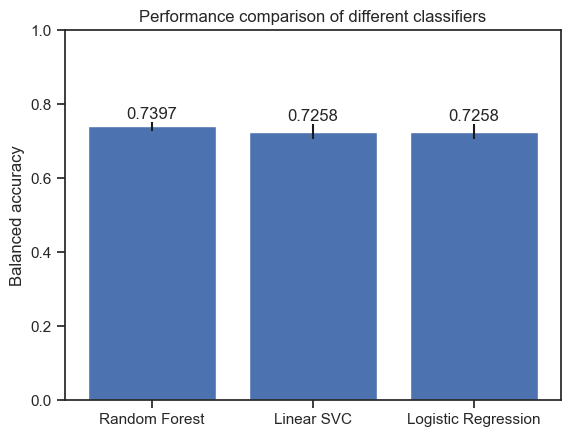

In [207]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Random Forest", "Linear SVC", "Logistic Regression"], height=[np.mean(i) for i in baclist], 
              yerr=[np.std(i) for i in baclist])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel=None, ylabel="Balanced accuracy", title="Performance comparison of different classifiers", ylim=(0.0, 1))
plt.show()

fig.savefig(fig_path + "Comparison_classifier_performance_BAC.png", bbox_inches="tight")

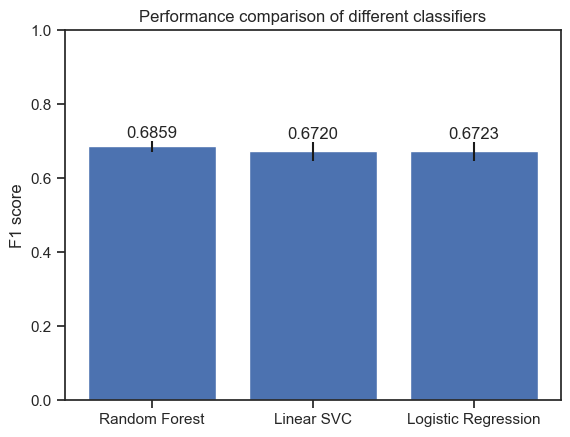

In [208]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Random Forest", "Linear SVC", "Logistic Regression"], height=[np.mean(i) for i in f1list], 
    yerr=[np.std(i) for i in f1list])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel=None, ylabel="F1 score", title="Performance comparison of different classifiers", ylim=(0.0, 1))
plt.show()

fig.savefig(fig_path + "Comparison_classifier_performance_F1.png", bbox_inches="tight")

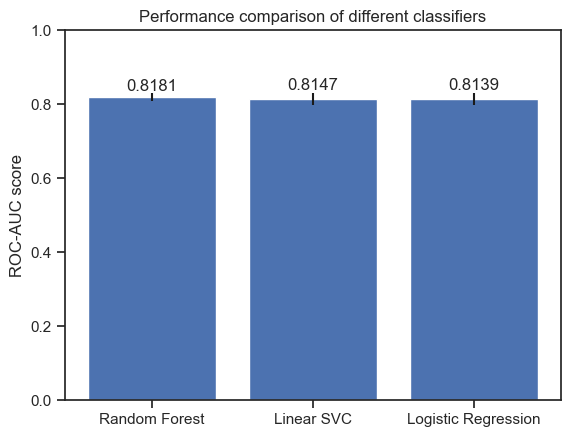

In [209]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Random Forest", "Linear SVC", "Logistic Regression"], height=[np.mean(i) for i in auclist], 
    yerr=[np.std(i) for i in auclist])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel=None, ylabel="ROC-AUC score", title="Performance comparison of different classifiers", ylim=(0.0, 1))
plt.show()

fig.savefig(fig_path + "Comparison_classifier_performance_AUC.png", bbox_inches="tight")

## Hyperparameter tuning

In [53]:
# preprocessing data 
X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y)

In [54]:
# save the scaler
with open(os.getcwd() + "/Models/Standard_scaler.pkl", "wb") as f:  
    pickle.dump(scaler, f)

### Linear SVC (L2 regularization)

In [212]:
parameters = {"C":[0.01, 0.1, 1, 10]}
svc_l2 = LinearSVC(penalty="l2", dual=False, random_state=0)
grs_svc_l2 = GridSearchCV(svc_l2, parameters, cv=10)
grs_svc_l2.fit(X_train_bal, y_train_bal)

grid_results_svc_l2 = pd.DataFrame(grs_svc_l2.cv_results_).sort_values("param_C")
grid_results_svc_l2.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.045676,0.005735,0.002409,0.003680,0.1,{'C': 0.1},0.73750,0.74375,0.735849,0.742138,0.729560,0.729560,0.672956,0.773585,0.685535,0.723270,0.727370,0.027449,1
3,0.079608,0.012683,0.003929,0.006319,10,{'C': 10},0.74375,0.74375,0.735849,0.748428,0.729560,0.723270,0.685535,0.754717,0.672956,0.735849,0.727366,0.025699,2
2,0.063307,0.009804,0.003637,0.006186,1,{'C': 1},0.73750,0.73750,0.735849,0.742138,0.735849,0.723270,0.685535,0.754717,0.672956,0.723270,0.724858,0.024488,3
0,0.029433,0.003165,0.001599,0.003198,0.01,{'C': 0.01},0.73125,0.71875,0.729560,0.723270,0.710692,0.742138,0.666667,0.754717,0.698113,0.723270,0.719843,0.023122,4


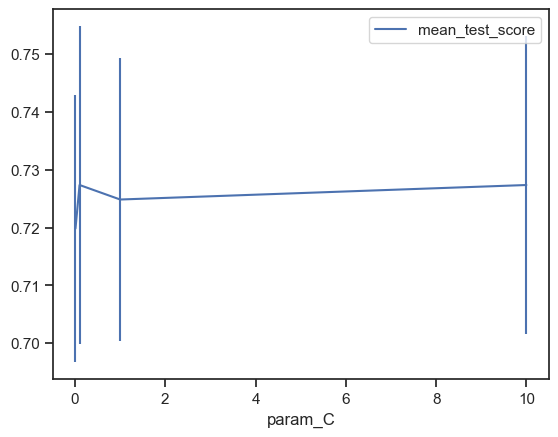

In [213]:
grid_results_svc_l2.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

### Linear SVC (L1 regularization)

In [214]:
parameters = {"C":[0.01, 0.1, 1, 10]}
svc_l1 = LinearSVC(penalty="l1", max_iter=10000, dual=False, random_state=0)
grs_svc_l1 = GridSearchCV(svc_l1, parameters, cv=10)
grs_svc_l1.fit(X_train_bal, y_train_bal)

grid_results_svc_l1 = pd.DataFrame(grs_svc_l1.cv_results_).sort_values("param_C")
grid_results_svc_l1.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,1.847270,0.202299,0.002363,0.005024,10,{'C': 10},0.74375,0.74375,0.735849,0.748428,0.729560,0.723270,0.685535,0.754717,0.672956,0.735849,0.727366,0.025699,1
2,1.126378,0.149565,0.003921,0.006299,1,{'C': 1},0.73750,0.74375,0.735849,0.742138,0.729560,0.723270,0.685535,0.748428,0.679245,0.716981,0.724226,0.022806,2
0,0.031056,0.002607,0.005533,0.006998,0.01,{'C': 0.01},0.75000,0.72500,0.704403,0.754717,0.679245,0.716981,0.679245,0.742138,0.735849,0.735849,0.722343,0.025772,3
1,0.118454,0.035047,0.004349,0.006175,0.1,{'C': 0.1},0.71875,0.72500,0.735849,0.710692,0.710692,0.729560,0.672956,0.779874,0.685535,0.723270,0.719218,0.027446,4


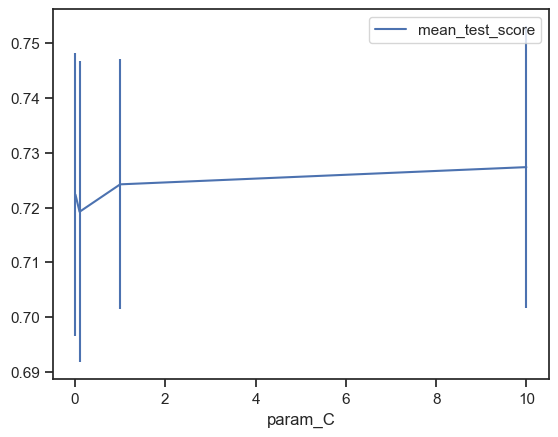

In [215]:
grid_results_svc_l1.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

### Logistic Regression (L2 regularization)

In [216]:
parameters = {"C":[0.01, 0.1, 1, 10]}
lr_l2 = LogisticRegression(penalty="l2", max_iter=1000, dual=False, random_state=0)
grs_lr_l2 = GridSearchCV(lr_l2, parameters, cv=10, scoring="balanced_accuracy")
grs_lr_l2.fit(X_train_bal, y_train_bal)

grid_results_lr_l2 = pd.DataFrame(grs_lr_l2.cv_results_).sort_values("param_C")
grid_results_lr_l2.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2,0.078549,0.010205,0.002424,0.005095,1,{'C': 1},0.74375,0.74375,0.742009,0.748655,0.723418,0.717009,0.666693,0.767326,0.685206,0.710839,0.724866,0.029315,1
3,0.170150,0.016656,0.004565,0.006205,10,{'C': 10},0.74375,0.73750,0.742009,0.754905,0.717326,0.710759,0.666535,0.754747,0.678956,0.723418,0.722991,0.028876,2
1,0.041492,0.007005,0.004687,0.007160,0.1,{'C': 0.1},0.72500,0.71875,0.716693,0.729826,0.710918,0.735839,0.673101,0.760918,0.710443,0.729589,0.721108,0.021242,3
0,0.024381,0.007075,0.002802,0.004989,0.01,{'C': 0.01},0.70000,0.73125,0.653797,0.685839,0.691930,0.735759,0.679430,0.742168,0.723180,0.742405,0.708576,0.029081,4


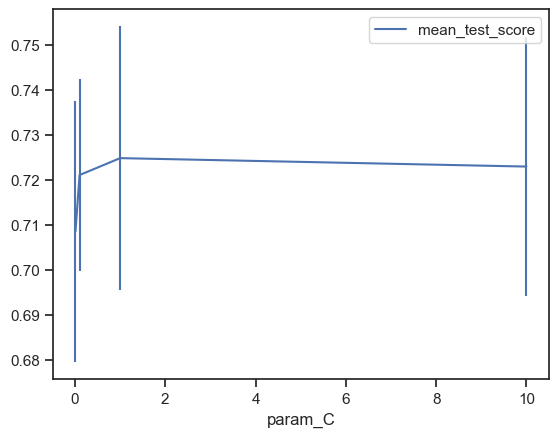

In [217]:
grid_results_lr_l2.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

### Logistic Regression (L1 regularization)

In [218]:
parameters = {"C":[0.01, 0.1, 1, 10]}
lr_l1 = LogisticRegression(penalty="l1", solver="saga", max_iter=10000, dual=False, random_state=0)
grs_lr_l1 = GridSearchCV(lr_l1, parameters, cv=10, scoring="balanced_accuracy")
grs_lr_l1.fit(X_train_bal, y_train_bal)

grid_results_lr_l1 = pd.DataFrame(grs_lr_l1.cv_results_).sort_values("param_C")
grid_results_lr_l1.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,9.986262,1.412072,0.004066,0.006236,10,{'C': 10},0.74375,0.73750,0.742009,0.754905,0.723576,0.710759,0.666535,0.754747,0.672627,0.723418,0.722983,0.029840,1
1,0.395239,0.092735,0.003922,0.006310,0.1,{'C': 0.1},0.75000,0.71875,0.704035,0.748655,0.685759,0.735839,0.679351,0.754589,0.716851,0.717247,0.721108,0.025010,2
2,3.173891,1.009477,0.001563,0.004690,1,{'C': 1},0.73750,0.73125,0.742009,0.736076,0.717168,0.704351,0.660443,0.767326,0.672627,0.717089,0.718584,0.030738,3
0,0.049460,0.008812,0.007819,0.007096,0.01,{'C': 0.01},0.53750,0.66250,0.571994,0.641614,0.578244,0.628877,0.604114,0.654589,0.616851,0.597706,0.609399,0.037468,4


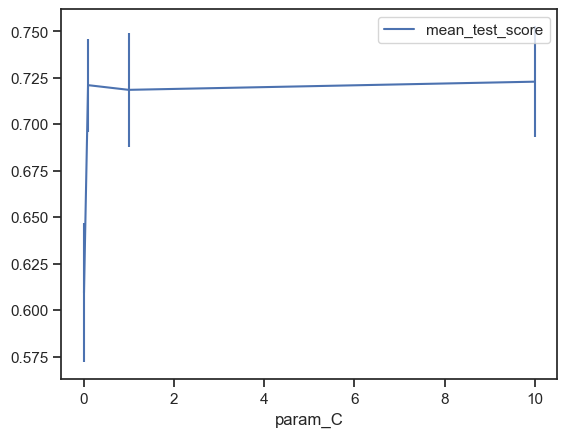

In [219]:
grid_results_lr_l1.plot(x="param_C", y="mean_test_score", yerr="std_test_score")
plt.show()

## Regularization parameter C

In [72]:
def test_regularization(X, y, C_vals = [0.01, 0.1, 0.5, 1, 5], model="LogisticRegression"):
    """
    """
    
    # create empty dictionaries to save results to
    bac_all = {}
    feature_num_all = {} 
    
    bac_l2 = []
    feature_num_l2 = []
    
    bac_none = []
    feature_num_none = []

    # calculate accuracy and feature number for L1 regularized models
    for n, C in enumerate(C_vals):
        
        bac = []
        feature_num = []
        
        for i in range(10):

            X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y, random_state=i)
            if model == "LogisticRegression":
                clf_l1 = LogisticRegression(penalty="l1", solver="saga", C=C, max_iter=10000, dual=False, random_state=0)
            elif model == "LinearSVC":
                clf_l1 = LinearSVC(penalty="l1", C=C, max_iter=10000, dual=False, random_state=0)  
            else:
                return "Please choose LogisticRegression or LinearSVC as a model."
            
            clf_l1.fit(X_train_bal, y_train_bal)
            y_pred_l1 = clf_l1.predict(X_test_scal)
            
            # add results to list
            bac.append(balanced_accuracy_score(y_test, y_pred_l1))
            feature_num.append(sum((clf_l1.coef_[0] != 0)))
            
            # after last C value calculate accuracy and feature number for L2 & non-regularized models
            if n == (len(C_vals)-1):

                if model == "LogisticRegression":
                    clf_l2 = LogisticRegression(penalty="l2", C=0.1, max_iter=10000, dual=False, random_state=0)
                    clf_none = LogisticRegression(penalty="none", max_iter=10000, dual=False, random_state=0)
                elif model == "LinearSVC":
                    clf_l2 = LinearSVC(penalty="l2", C=0.1, max_iter=10000, dual=False, random_state=0)
#                     clf_none = LinearSVC(penalty="none", max_iter=10000, dual=False, random_state=0)
                else:
                    return "Please choose LogisticRegression or LinearSVC as a model."
            
                # L2 regularized models
                clf_l2.fit(X_train_bal, y_train_bal)
                y_pred_l2 = clf_l2.predict(X_test_scal)

                feature_num_l2.append(sum((clf_l2.coef_[0] != 0)))
                bac_l2.append(balanced_accuracy_score(y_test, y_pred_l2))            
                
                if model == "LogisticRegression":
                    # unregularized models
                    clf_none.fit(X_train_bal, y_train_bal)
                    y_pred_none = clf_none.predict(X_test_scal)

                    feature_num_none.append(sum((clf_none.coef_[0] != 0)))
                    bac_none.append(balanced_accuracy_score(y_test, y_pred_none))  
        
        # add results to dictionaries
        bac_all[C] = bac
        feature_num_all[C] = feature_num   
        
        if n == (len(C_vals)-1):
            bac_all["L2"] = bac_l2          
            feature_num_all["L2"] = feature_num_l2
            if model == "LogisticRegression":
                bac_all["None"] = bac_none          
                feature_num_all["None"] = feature_num_none
        
    return bac_all, feature_num_all

In [63]:
C_vals = [0.01, 0.1, 0.5, 1, 5]
bac_all_lr, feature_num_all_lr = test_regularization(X, y, C_vals=C_vals, model="LogisticRegression")

In [70]:
# p-values for accuracy of L2 regularized model vs. L1 regularized models
p_vals = []

for C in C_vals + ["L2"]:
    _, p = ttest_ind(bac_all_lr["None"], bac_all_lr[C])
    p_vals.append(p)
    print("C:", C, "   p-value:", print_p_val(p))

C: 0.01    p-value: < 0.0001
C: 0.1    p-value: 0.6870
C: 0.5    p-value: 0.8948
C: 1    p-value: 0.8512
C: 5    p-value: 0.8445
C: L2    p-value: 0.6386


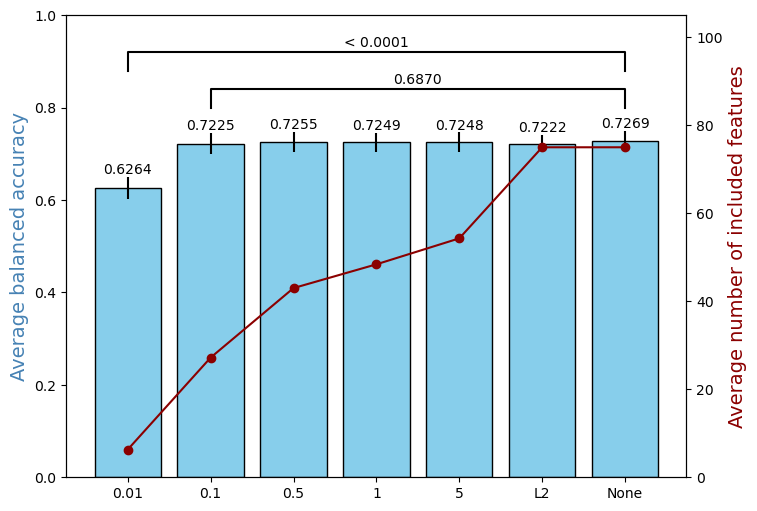

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

bars = plt.bar(x=[str(i) for i in bac_all_lr.keys()], height=[np.mean(bac) for bac in bac_all_lr.values()], 
        yerr=[np.std(bac) for bac in bac_all_lr.values()], color=["skyblue"], edgecolor="black")
ax.bar_label(bars, fmt="%.4f")

# add p-value annotations
r, h = 0.8, 0.04
ax.plot([1, 1, 6, 6], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(3.5, r+0.045, print_p_val(p_vals[1]), ha="center", va="bottom", color="black")
r, h = 0.88, 0.04
ax.plot([0, 0, 6, 6], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(3, r+0.045, print_p_val(p_vals[0]), ha="center", va="bottom", color="black")

ax.set(ylim=(0,1))
ax.set_ylabel("Average balanced accuracy", color="steelblue", fontsize=14)

ax2=ax.twinx() # two y-axes in same plot
ax2.set(ylim=(0,105))
# make a plot with different y-axis using second axis object
ax2.plot([str(i) for i in bac_all_lr.keys()], [np.mean(f) for f in feature_num_all_lr.values()], color="darkred", marker="o")
ax2.set_ylabel("Average number of included features", color="darkred", fontsize=14)

plt.show()
fig.savefig(fig_path + "Logistic_classifier_regularized_BAC.png", bbox_inches="tight", dpi=300)

In [73]:
bac_all_svc, feature_num_all_svc = test_regularization(X, y, C_vals=C_vals, model="LinearSVC")

C:\Users\kathi\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [74]:
# p-values for accuracy of L2 regularized model vs. L1 regularized models
p_vals = []

for C in C_vals:
    _, p = ttest_ind(bac_all_svc["L2"], bac_all_svc[C])
    p_vals.append(p)
    print("C:", C, "   p-value:", print_p_val(p))

C: 0.01    p-value: 0.2757
C: 0.1    p-value: 0.8941
C: 0.5    p-value: 0.9555
C: 1    p-value: 0.8863
C: 5    p-value: 0.9539


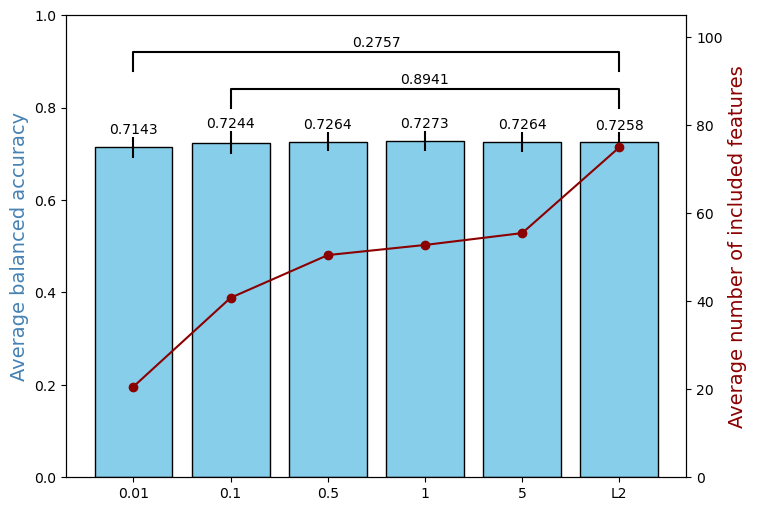

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

bars = plt.bar(x=[str(i) for i in bac_all_svc.keys()], height=[np.mean(bac) for bac in bac_all_svc.values()], 
        yerr=[np.std(bac) for bac in bac_all_svc.values()], color=["skyblue"], edgecolor="black")
ax.bar_label(bars, fmt="%.4f")

# add p-value annotations
r, h = 0.8, 0.04
ax.plot([1, 1, 5, 5], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(3, r+0.045, print_p_val(p_vals[1]), ha="center", va="bottom", color="black")
r, h = 0.88, 0.04
ax.plot([0, 0, 5, 5], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(2.5, r+0.045, print_p_val(p_vals[0]), ha="center", va="bottom", color="black")

ax.set(ylim=(0,1))
ax.set_ylabel("Average balanced accuracy", color="steelblue", fontsize=14)

ax2=ax.twinx() # two y-axes in same plot
ax2.set(ylim=(0,105))
# make a plot with different y-axis using second axis object
ax2.plot([str(i) for i in bac_all_svc.keys()], [np.mean(f) for f in feature_num_all_svc.values()], color="darkred", marker="o")
ax2.set_ylabel("Average number of included features", color="darkred", fontsize=14)

plt.show()
fig.savefig(fig_path + "Linear_SVC_regularized_BAC.png", bbox_inches="tight", dpi=300)

## Final models & feature importance

In [14]:
X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y)

### Random Forest

In [15]:
# train RF
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_rf = rf.predict(X_test_scal)
y_score_rf = rf.predict_proba(X_test_scal)

In [16]:
coef_rf = pd.Series(index=X_train_bal.columns, data=rf.feature_importances_, name="RF")
print("Number of features used:", len(coef_rf[coef_rf != 0]))
coef_rf.sort_values(ascending=False, key=abs)[:20]

Number of features used: 55


Helix_NSP            0.046624
Signal peptide       0.041085
Solubility           0.039370
Sheet_NSP            0.037718
ExpAA                0.036900
L                    0.032619
D                    0.031558
Isoelectric point    0.031439
C                    0.029733
Turn_NSP             0.029338
Length               0.028944
H                    0.028622
Molecular weight     0.028402
F                    0.028288
G                    0.028141
V                    0.027380
W                    0.027351
R                    0.026844
K                    0.026802
Nucleus              0.026415
Name: RF, dtype: float64

### Linear SVC (L2 regularization)

In [17]:
# train SVC , penalty = l2
svc_l2 = LinearSVC(C=0.1, max_iter=10000, dual=False, random_state=0)
svc_l2.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_svc_l2 = svc_l2.predict(X_test_scal)
y_score_svc_l2 = svc_l2.decision_function(X_test_scal)

In [18]:
# save the model 
with open(os.getcwd() + "/Models/SVC_L2.pkl", "wb") as f:  
    pickle.dump(svc_l2, f)

In [19]:
coef_svc_l2 = pd.Series(index=X_train_bal.columns, data=svc_l2.coef_[0], name="SVC_L2")
print("Number of features used:", len(coef_svc_l2[coef_svc_l2 != 0]))
coef_svc_l2.sort_values(ascending=False, key=abs)[:20]

Number of features used: 55


Nucleus             -0.527004
Signal peptide       0.468468
PS00027             -0.462711
Peroxisome          -0.395088
Golgi_apparatus      0.392300
PS00028             -0.383766
PS00022              0.329693
Extracellular        0.310265
PredHel_binary       0.277541
ExpAA                0.230393
PS01186              0.210988
PredHel             -0.189999
GlycoMine_C          0.168672
Length               0.155127
K                    0.151631
PS00237             -0.145495
Solubility           0.120189
G                    0.113830
Isoelectric point   -0.112979
W                   -0.108986
Name: SVC_L2, dtype: float64

### Linear SVC (L1 regularization)

In [20]:
# train SVC , penalty = l1
svc_l1 = LinearSVC(penalty="l1", C=0.1, max_iter=10000, dual=False, random_state=0)
svc_l1.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_svc_l1 = svc_l1.predict(X_test_scal)
y_score_svc_l1 = svc_l1.decision_function(X_test_scal)

In [21]:
coef_svc_l1 = pd.Series(index=X_train_bal.columns, data=svc_l1.coef_[0], name="SVC_L1")
print("Number of features used:", len(coef_svc_l1[coef_svc_l1 != 0]))
coef_svc_l1[coef_svc_l1 != 0].sort_values(ascending=False, key=abs)[:20]

Number of features used: 39


Nucleus             -0.518638
Signal peptide       0.499056
Golgi_apparatus      0.357875
Extracellular        0.242136
PS00027             -0.230005
PredHel_binary       0.222805
PS00022              0.219716
PS00028             -0.161173
K                    0.129103
G                    0.106510
W                   -0.104524
Helix_NSP           -0.091914
Length               0.088921
Isoelectric point   -0.079930
Solubility           0.074858
L                   -0.074477
GlycoMine_O          0.069436
I                   -0.067106
Sheet_NSP            0.060754
Q                    0.058989
H                   -0.058370
S                   -0.057264
A                    0.049912
T                    0.047822
First60ExpAA         0.047061
M                    0.045683
P                   -0.045469
V                    0.043473
C                   -0.043040
F                   -0.041027
D                    0.040824
ExpAA                0.036547
E                   -0.032735
Disorder_N

In [22]:
print("Number of ignored features:", len(coef_svc_l1[coef_svc_l1 == 0]))
coef_svc_l1[coef_svc_l1 == 0]

Number of ignored features: 16


Molecular weight         0.0
N                        0.0
Y                        0.0
Turn_NSP                 0.0
PredHel                  0.0
Lysosome/Vacuole         0.0
Cell_membrane            0.0
Endoplasmic_reticulum    0.0
Mitochondrion            0.0
Peroxisome               0.0
Plastid                  0.0
PS00232                  0.0
PS00237                  0.0
PS01186                  0.0
GlycoMine_C              0.0
GPI-anchor               0.0
Name: SVC_L1, dtype: float64

### Logistic Regression (L2 regularization)

In [23]:
# train logistic classifier, penalty = l2
lr_l2 = LogisticRegression(penalty="l2", C=1, max_iter=1000, dual=False, random_state=0)
lr_l2.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_lr_l2 = lr_l2.predict(X_test_scal)
y_score_lr_l2 = lr_l2.decision_function(X_test_scal)

In [24]:
# save the model 
with open(os.getcwd() + "/Models/LogisticClassifier_L2.pkl", "wb") as f:  
    pickle.dump(lr_l2, f)

In [25]:
coef_lr_l2 = pd.Series(index=X_train_bal.columns, data=lr_l2.coef_[0], name="LR_L2")
print("Number of features used:", len(coef_lr_l2[coef_lr_l2 != 0]))
coef_lr_l2.sort_values(ascending=False, key=abs)[:20]

Number of features used: 55


PS00027                 -1.468945
PS00028                 -1.311571
Nucleus                 -1.277299
Signal peptide           1.234190
Golgi_apparatus          0.985557
PS00022                  0.978452
Peroxisome              -0.936783
Extracellular            0.914554
PredHel_binary           0.768485
PS01186                  0.676236
ExpAA                    0.564033
PredHel                 -0.466013
GlycoMine_C              0.426150
Length                   0.394119
K                        0.381928
PS00232                  0.353126
PS00237                 -0.347345
G                        0.312683
Isoelectric point       -0.300342
Solubility               0.295273
W                       -0.290938
GlycoMine_O              0.285945
GPI-anchor               0.223501
E                       -0.223352
Lysosome/Vacuole         0.216375
L                       -0.199834
I                       -0.198064
P                       -0.196214
Disorder_NSP            -0.189135
Helix_NSP     

### Logistic Regression (L1 regularization)

In [27]:
# train logistic classifier, penalty = l1
lr_l1 = LogisticRegression(penalty="l1", solver="saga", C=0.1, max_iter=10000, dual=False, random_state=0)
lr_l1.fit(X_train_bal, y_train_bal)

# predict on test set
y_pred_lr_l1 = lr_l1.predict(X_test_scal)
y_score_lr_l1 = lr_l1.decision_function(X_test_scal)

In [28]:
# save the model 
with open(os.getcwd() + "/Models/LogisticClassifier_L1.pkl", "wb") as f:  
    pickle.dump(lr_l1, f)

In [29]:
coef_lr_l1 = pd.Series(index=X_train_bal.columns, data=lr_l1.coef_[0], name="LR_L1")
print("Number of features used:", len(coef_lr_l1[coef_lr_l1 != 0]))
coef_lr_l1.sort_values(ascending=False, key=abs)[:20]

Number of features used: 30


Signal peptide       1.243243
Nucleus             -1.096290
PredHel_binary       0.484721
W                   -0.243837
Sheet_NSP            0.232363
L                   -0.208445
Length               0.204877
G                    0.187577
H                   -0.175780
K                    0.165271
First60ExpAA         0.149413
S                   -0.123049
Isoelectric point   -0.119764
Solubility           0.119085
F                   -0.118726
D                    0.106619
Extracellular        0.094246
I                   -0.090677
Q                    0.088553
Helix_NSP           -0.085634
Golgi_apparatus      0.063668
C                   -0.055080
V                    0.050170
T                    0.044337
P                   -0.043402
M                    0.032778
A                    0.020281
GlycoMine_O          0.009890
Glycosylation        0.007711
Name: LR_L1, dtype: float64

In [30]:
print("Number of ignored features:", len(coef_lr_l1[coef_lr_l1 == 0]))
coef_lr_l1[coef_lr_l1 == 0]

Number of ignored features: 25


Molecular weight         0.0
E                        0.0
N                        0.0
R                        0.0
Y                        0.0
Instability index        0.0
Disorder_NSP             0.0
Turn_NSP                 0.0
PredHel                  0.0
Cytoplasm                0.0
Lysosome/Vacuole         0.0
Cell_membrane            0.0
Endoplasmic_reticulum    0.0
Mitochondrion            0.0
Peroxisome               0.0
Plastid                  0.0
PS00232                  0.0
PS00237                  0.0
PS00027                  0.0
PS00028                  0.0
PS00022                  0.0
PS01186                  0.0
GlycoMine_N              0.0
GlycoMine_C              0.0
GPI-anchor               0.0
Name: LR_L1, dtype: float64

## Model performance

In [31]:
models = [rf, svc_l2, svc_l1, lr_l2, lr_l1]
model_names = ["Random Forest", "SVC (L2)", "SVC (L1)", "Logistic Classifier (L2)", "Logistic Classifier (L1)"]

### ROC-AUC

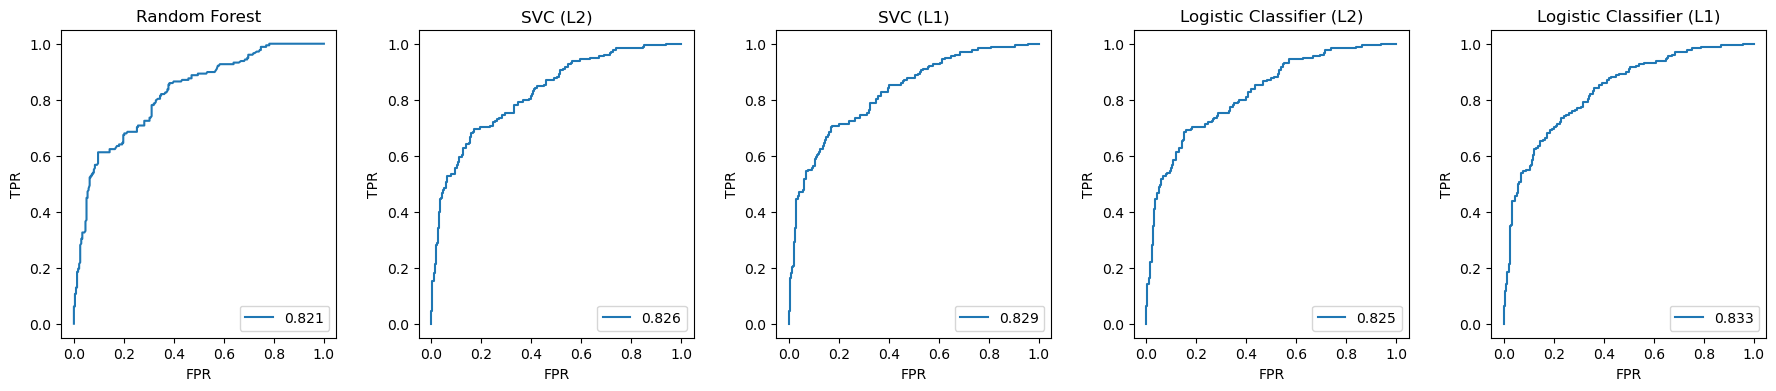

In [32]:
fig, ax = plt.subplots(1, len(models), figsize=(22, 4))
fig.subplots_adjust(wspace=0.3)

for i in range(len(models)):
    RocCurveDisplay.from_estimator(models[i], X_test_scal, y_test, ax=ax[i])
    ax[i].set(xlabel="FPR", ylabel="TPR", title=model_names[i])
#     ax[i].legend(labels=[round(roc_auc_score(y_test, models[i].decision_function(X_test_scal)), 3)], loc="lower right")
    try:
        ax[i].legend(labels=[round(roc_auc_score(y_test, models[i].predict_proba(X_test_scal)[:, 1]), 3)], loc="lower right")
    except:
        ax[i].legend(labels=[round(roc_auc_score(y_test, models[i].decision_function(X_test_scal)), 3)], loc="lower right")

plt.show()
fig.savefig(fig_path + "Final_models_AUC_ROC_curve.png", bbox_inches="tight")

### Confusion matrix

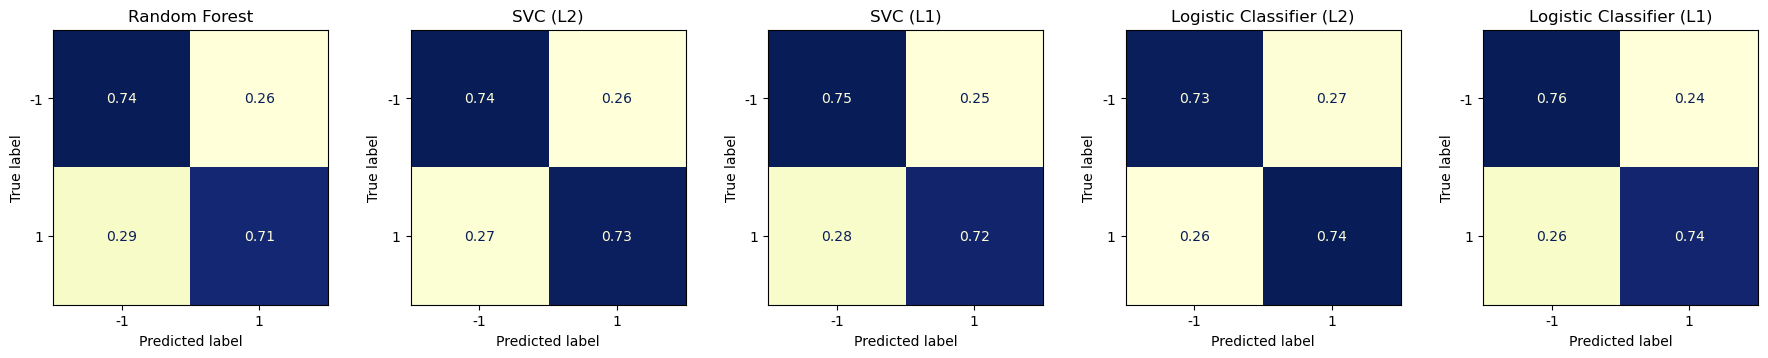

In [33]:
fig, ax = plt.subplots(1, 5, figsize=(22, 4))
fig.subplots_adjust(wspace=0.3)

for i in range(5):
    ConfusionMatrixDisplay.from_estimator(models[i], X_test_scal, y_test, normalize="true", colorbar=False, cmap="YlGnBu", 
        ax=ax[i])
    ax[i].set(title=model_names[i])

plt.show()
fig.savefig(fig_path + "Final_models_confusion_matrix.png", bbox_inches="tight")

## Feature importance

In [34]:
rank_rf = abs(coef_rf).rank().sort_values()
rank_svc_l2 = abs(coef_svc_l2).rank().sort_values()
rank_svc_l1 = abs(coef_svc_l1[coef_svc_l1 != 0]).rank().sort_values()
rank_lr_l2 = abs(coef_lr_l2).rank().sort_values()
rank_lr_l1 = abs(coef_lr_l1[coef_lr_l1 != 0]).rank().sort_values()

In [35]:
all_ranks = pd.merge(rank_rf, rank_svc_l2, left_index=True, right_index=True, how="outer")
all_ranks = pd.merge(all_ranks, rank_svc_l1, left_index=True, right_index=True, how="outer")
all_ranks = pd.merge(all_ranks, rank_lr_l2, left_index=True, right_index=True, how="outer")
all_ranks = pd.merge(all_ranks, rank_lr_l1, left_index=True, right_index=True, how="outer")
all_ranks.fillna(0, inplace=True)
all_ranks["Mean"] = all_ranks.mean(axis=1)
all_ranks.sort_values("Mean", ascending=False, inplace=True)
all_ranks[:5]

,RF,SVC_L2,SVC_L1,LR_L2,LR_L1,Mean
Signal peptide,54.0,54.0,38.0,52.0,30.0,45.6
Nucleus,36.0,55.0,39.0,53.0,29.0,42.4
Length,45.0,42.0,27.0,42.0,24.0,36.0
PredHel_binary,20.0,47.0,34.0,47.0,28.0,35.2
K,37.0,41.0,31.0,41.0,21.0,34.2
G,41.0,38.0,30.0,38.0,23.0,34.0
Solubility,53.0,39.0,25.0,36.0,17.0,34.0
Extracellular,21.0,48.0,36.0,48.0,14.0,33.4
W,39.0,36.0,29.0,35.0,27.0,33.2
Isoelectric point,48.0,37.0,26.0,37.0,18.0,33.2


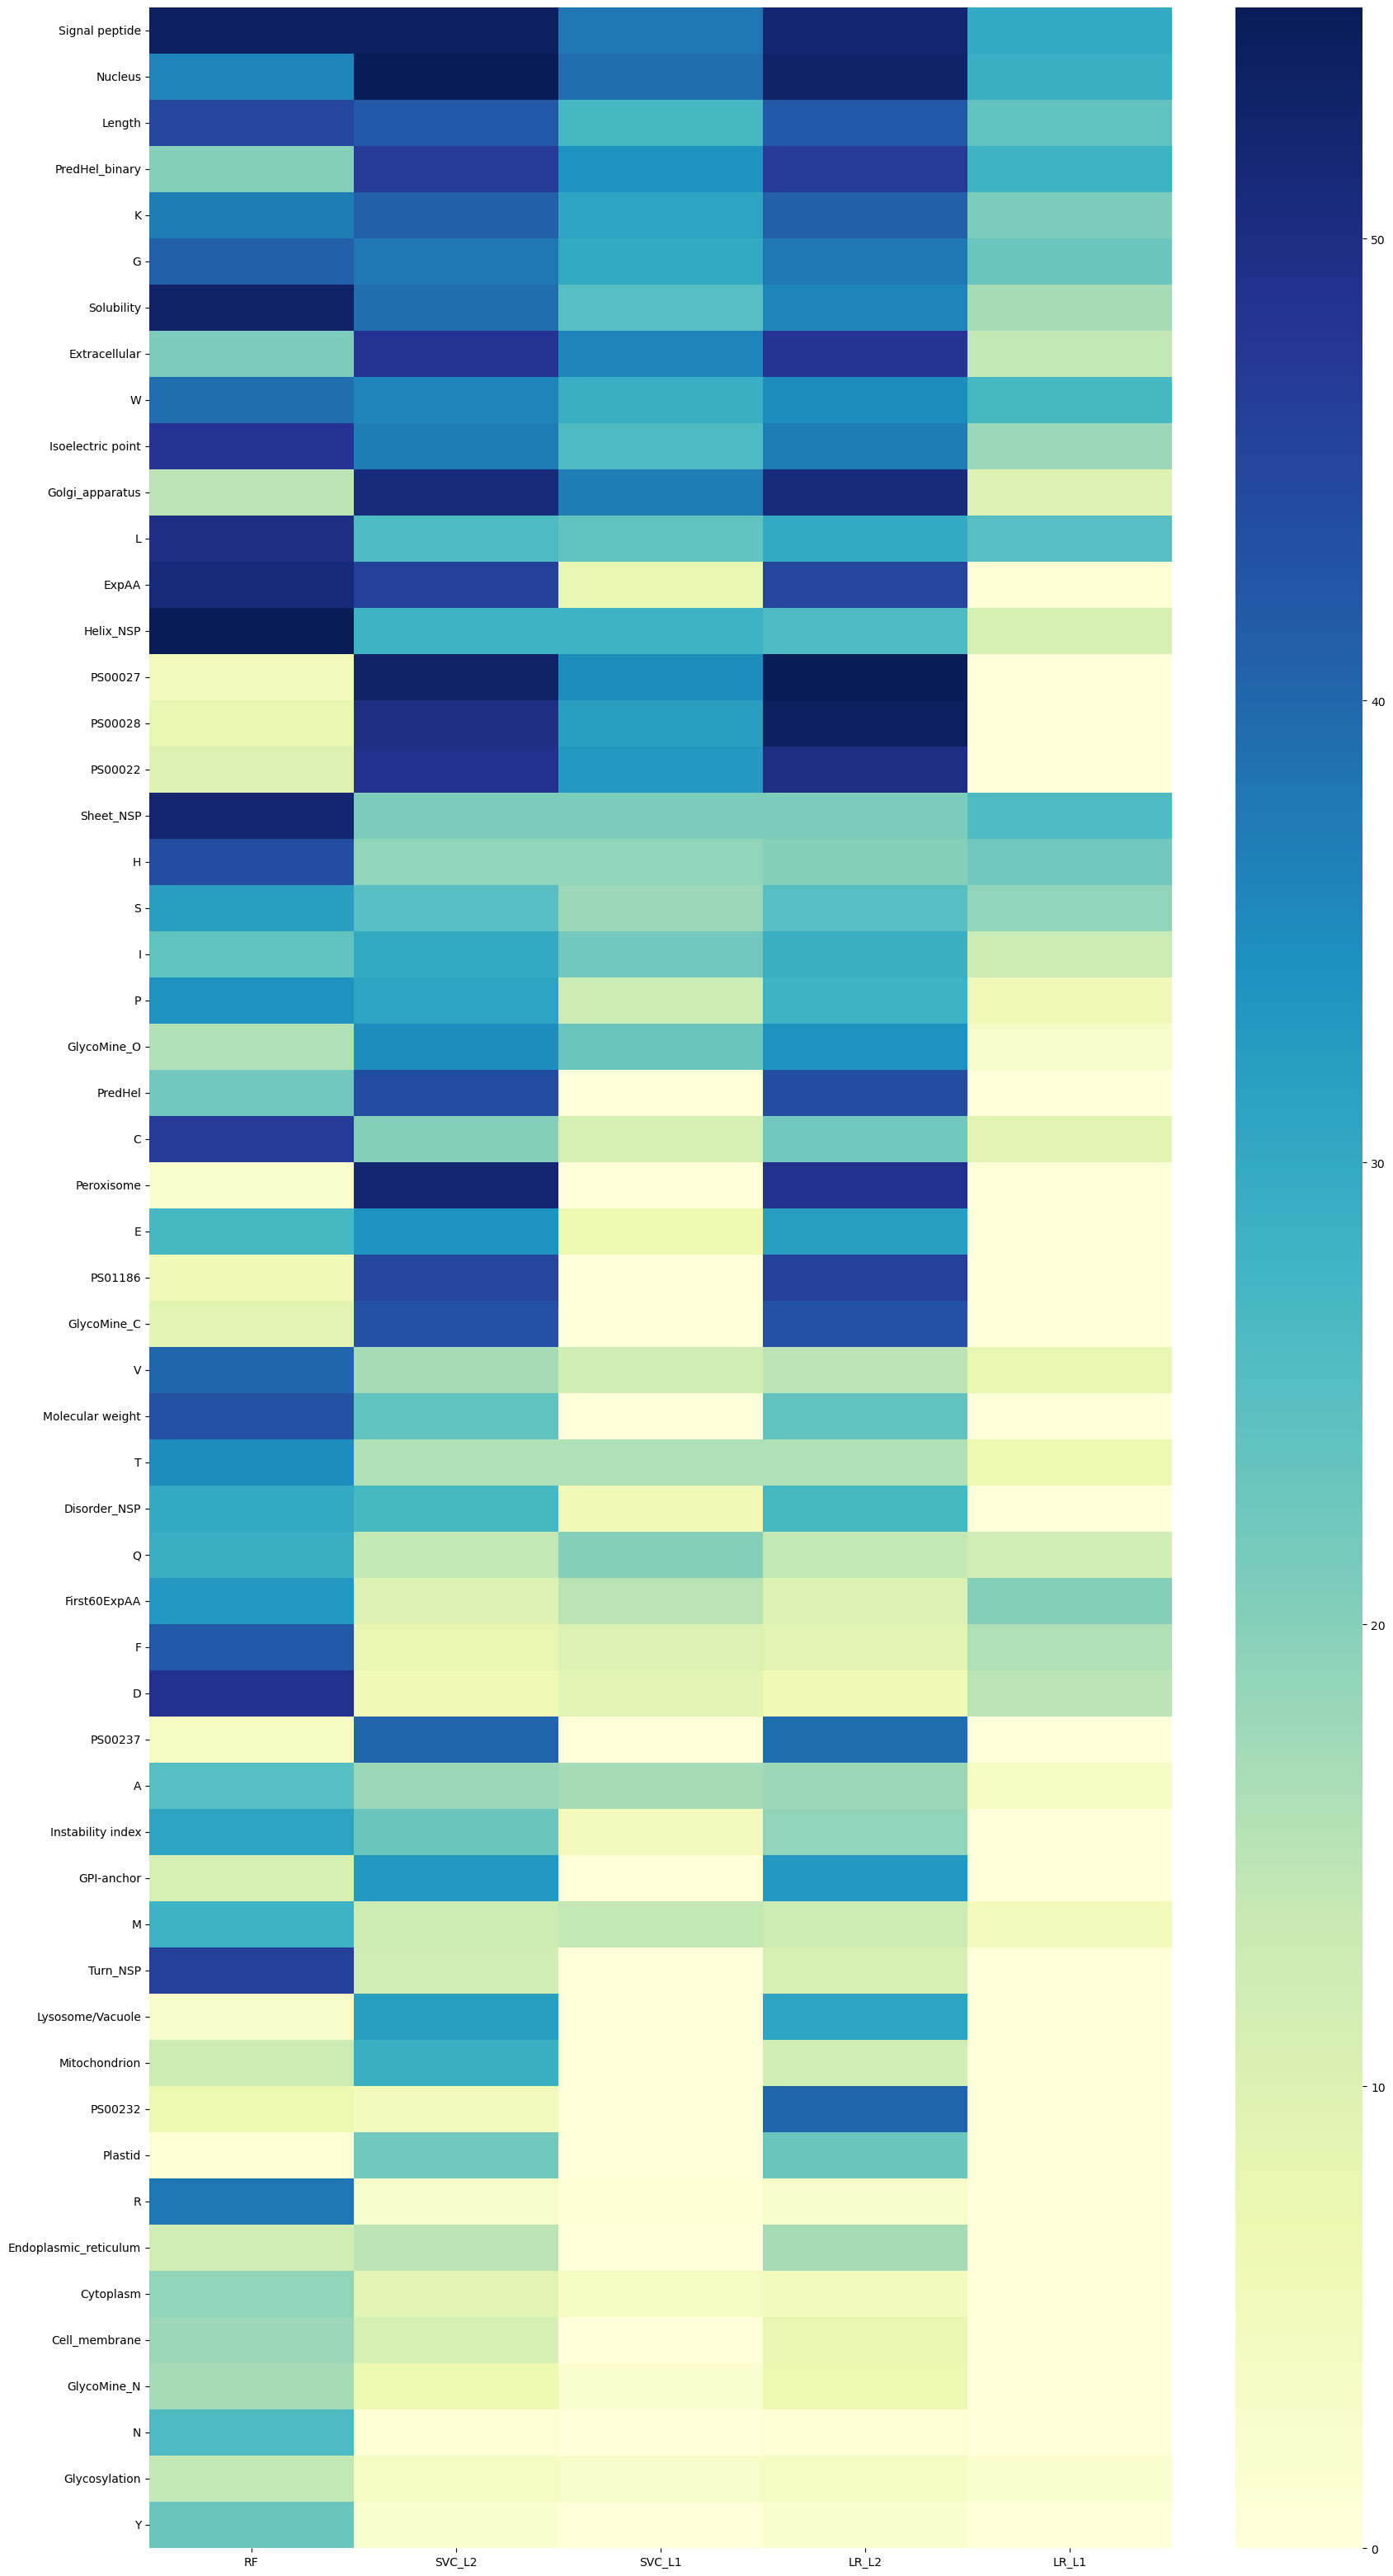

In [36]:
fig = plt.figure(figsize=(20, 40))

sns.heatmap(all_ranks[["RF", "SVC_L2", "SVC_L1", "LR_L2", "LR_L1"]], cmap="YlGnBu")

plt.show()
fig.savefig(fig_path + "Heatmap_feature_ranking.png", bbox_inches="tight")

## Dataset stringency

### CSF proteins

#### L1 regularization

In [38]:
baclist_csf_l1 = []
auclist_csf_l1 = []
coef_final_model_l1 = []

print("Number of non-CSF proteins:", len(df_features[df_features["CSF"] == -1]))

for i in range(1, csf["#Studies"].max()+1):
    print("-------------")
    print("Number of minimum CSF studies:", i)
    df_stringent = increase_stringency_CSF(df_features, csf, i)
    bac, auc, coefs, coef_final_model = accuracy_stringent(df_stringent, n=i, model="LogisticClassifier_L1")

    baclist_csf_l1.append(bac)
    auclist_csf_l1.append(auc)
    coef_final_model_l1.append(coef_final_model)

Number of non-CSF proteins: 1187
-------------
Number of minimum CSF studies: 1
Number of CSF proteins to be removed: 0
Number of CSF proteins left: 892
-------------
Number of minimum CSF studies: 2
Number of CSF proteins to be removed: 243
Number of CSF proteins left: 649
-------------
Number of minimum CSF studies: 3
Number of CSF proteins to be removed: 367
Number of CSF proteins left: 525
-------------
Number of minimum CSF studies: 4
Number of CSF proteins to be removed: 430
Number of CSF proteins left: 462
-------------
Number of minimum CSF studies: 5
Number of CSF proteins to be removed: 502
Number of CSF proteins left: 390
-------------
Number of minimum CSF studies: 6
Number of CSF proteins to be removed: 621
Number of CSF proteins left: 271


Number of features: 26


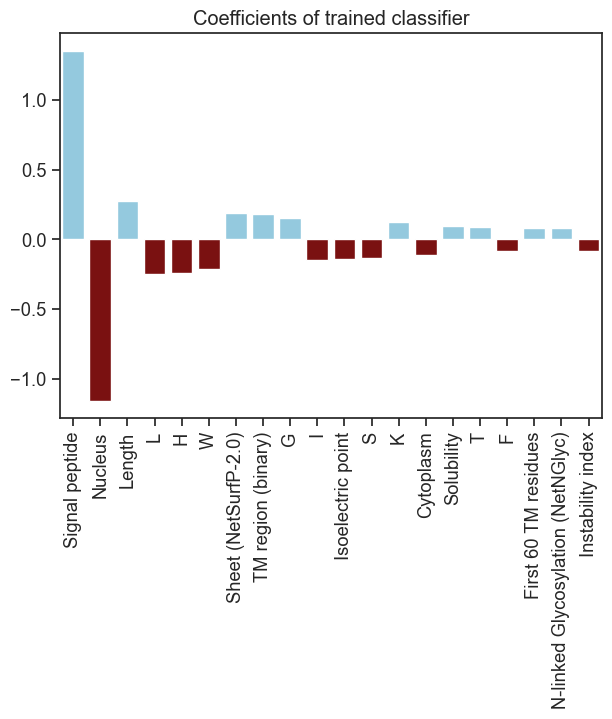

In [39]:
n = 1 # minimum study criterion 

print("Number of features:", len(coef_final_model_l1[n-1][coef_final_model_l1[n-1] != 0]))
coefs_plot_l1 = pd.DataFrame(coef_final_model_l1[n-1][:20])
coefs_plot_l1.rename(index=name_dict, inplace=True)
list_index_l1 = list(coefs_plot_l1.index)

sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

col = ["skyblue" if (x > 0) else "darkred" for x in coefs_plot_l1[n]]
coefs_plot_l1.index

sns.barplot(x=list_index_l1, y=n, data=coefs_plot_l1, palette=col)
ax.set(xlabel=None, ylabel=None, title="Coefficients of trained classifier")
# aplt.xticks(rotation=90)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()
fig.savefig(fig_path + "Logistic_classifier_coefficients_L1.png", bbox_inches="tight", dpi=300)

In [40]:
# p-values for accuracy of models with more stringent training data
p_vals_l1 = []

for i in range(len(baclist_csf_l1)-1):
    _, p = ttest_ind(baclist_csf_l1[i], baclist_csf_l1[i+1])
#     print("Comparison of %i and %i: %s" % (i+1, i+2, print_p_val(p)))
    p_vals_l1.append(p)
    
adjusted_p_bac_l1 = multipletests(p_vals_l1, alpha=0.05, method="fdr_bh")[1]

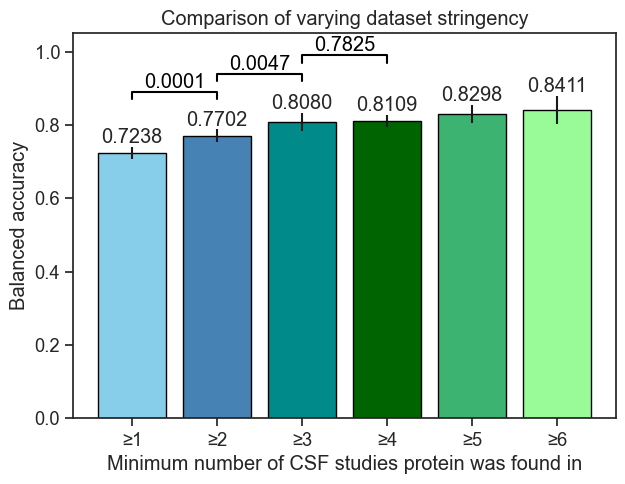

In [41]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

bars = ax.bar(x=["≥1","≥2","≥3","≥4","≥5","≥6"], height=[np.mean(i) for i in baclist_csf_l1], yerr=[np.std(i) for i in baclist_csf_l1], 
    color=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"], edgecolor="black")
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Minimum number of CSF studies protein was found in", ylabel="Balanced accuracy", 
    title="Comparison of varying dataset stringency", ylim=(0, 1.05))

# add p-value annotations
r, h = 0.87, 0.02
ax.plot([0, 0, 1, 1], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(0.5, r+0.02, print_p_val(adjusted_p_bac_l1[0]), ha="center", va="bottom", color="black")
r, h = 0.92, 0.02
ax.plot([1, 1, 2, 2], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(1.5, r+0.02, print_p_val(adjusted_p_bac_l1[1]), ha="center", va="bottom", color="black")
r, h = 0.97, 0.02
ax.plot([2, 2, 3, 3], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(2.5, r+0.02, print_p_val(adjusted_p_bac_l1[2]), ha="center", va="bottom", color="black")

plt.show()
fig.savefig(fig_path + "Increased_dataset_stringency_CSF_BAC_L1.png", bbox_inches="tight", dpi=300)

In [42]:
# p-values for accuracy of models with more stringent training data
p_vals_l1_auc = []

for i in range(len(auclist_csf_l1)-1):
    _, p = ttest_ind(auclist_csf_l1[i], auclist_csf_l1[i+1])
#     print("Comparison of %i and %i: %s" % (i+1, i+2, print_p_val(p)))
    p_vals_l1_auc.append(p)
    
adjusted_p_auc_l1 = multipletests(p_vals_l1_auc, alpha=0.05, method="fdr_bh")[1]

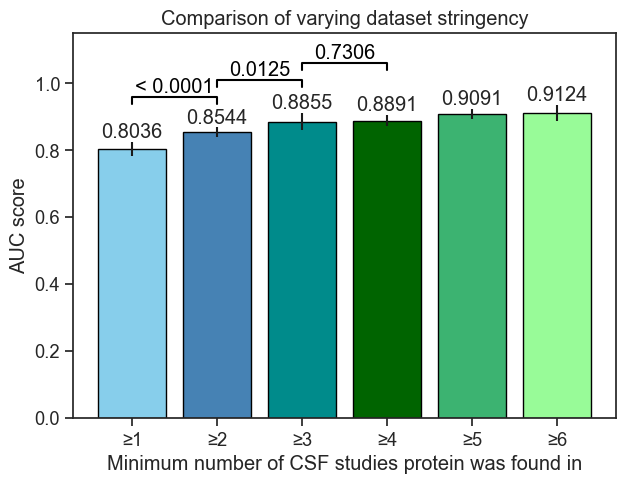

In [43]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

bars = ax.bar(x=["≥1","≥2","≥3","≥4","≥5","≥6"], height=[np.mean(i) for i in auclist_csf_l1], yerr=[np.std(i) for i in auclist_csf_l1],
    color=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"], edgecolor="black")
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Minimum number of CSF studies protein was found in", ylabel="AUC score", 
    title="Comparison of varying dataset stringency", ylim=(0, 1.15))

# add p-value annotations
r, h = 0.94, 0.02
ax.plot([0, 0, 1, 1], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(0.5, r+0.02, print_p_val(adjusted_p_auc_l1[0]), ha="center", va="bottom", color="black")
r, h = 0.99, 0.02
ax.plot([1, 1, 2, 2], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(1.5, r+0.02, print_p_val(adjusted_p_auc_l1[1]), ha="center", va="bottom", color="black")
r, h = 1.04, 0.02
ax.plot([2, 2, 3, 3], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(2.5, r+0.02, print_p_val(adjusted_p_auc_l1[2]), ha="center", va="bottom", color="black")

plt.show()

fig.savefig(fig_path + "Increased_dataset_stringency_CSF_AUC_L1.png", bbox_inches="tight", dpi=300)

#### L2 regularization

In [44]:
baclist_csf_l2 = []
auclist_csf_l2 = []
coefs_l2 = []
coef_final_model_l2 = []

print("Number of non-CSF proteins:", len(df_features[df_features["CSF"] == -1]))

for i in range(1, csf["#Studies"].max()+1):
    print("-------------")
    print("Number of minimum CSF studies:", i)
    df_stringent = increase_stringency_CSF(df_features, csf, i)
    bac, auc, coef, coef_final_model  = accuracy_stringent(df_stringent, n=i, model="LogisticClassifier_L2")

    baclist_csf_l2.append(bac)
    auclist_csf_l2.append(auc)
    coef_final_model_l2.append(coef_final_model)

Number of non-CSF proteins: 1187
-------------
Number of minimum CSF studies: 1
Number of CSF proteins to be removed: 0
Number of CSF proteins left: 892
-------------
Number of minimum CSF studies: 2
Number of CSF proteins to be removed: 243
Number of CSF proteins left: 649
-------------
Number of minimum CSF studies: 3
Number of CSF proteins to be removed: 367
Number of CSF proteins left: 525
-------------
Number of minimum CSF studies: 4
Number of CSF proteins to be removed: 430
Number of CSF proteins left: 462
-------------
Number of minimum CSF studies: 5
Number of CSF proteins to be removed: 502
Number of CSF proteins left: 390
-------------
Number of minimum CSF studies: 6
Number of CSF proteins to be removed: 621
Number of CSF proteins left: 271


Number of features: 55


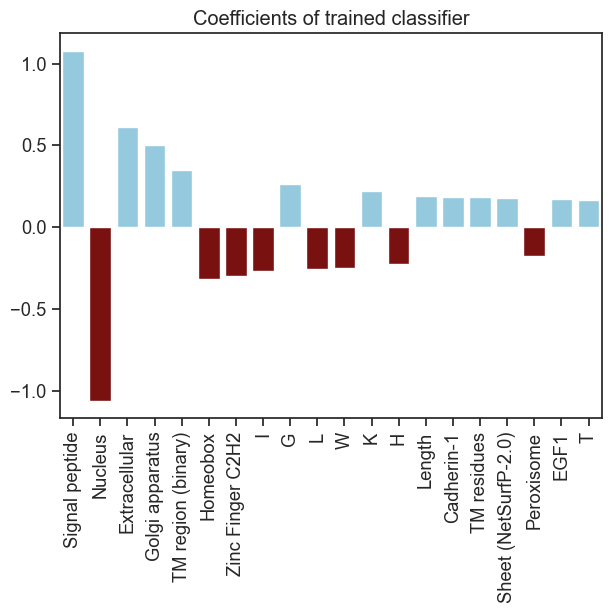

In [55]:
n = 1 # minimum study criterion 

print("Number of features:", len(coef_final_model_l2[n-1][coef_final_model_l2[n-1] != 0]))
coefs_plot_l2 = pd.DataFrame(coef_final_model_l2[n-1][:20])
coefs_plot_l2.rename(index=name_dict, inplace=True)
list_index_l2 = list(coefs_plot_l2.index)

sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

col = ["skyblue" if (x > 0) else "darkred" for x in coefs_plot_l2[n]]

sns.barplot(x=list_index_l2, y=n, data=coefs_plot_l2, palette=col)
ax.set(xlabel=None, ylabel=None, title="Coefficients of trained classifier")
# aplt.xticks(rotation=90)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()
fig.savefig(fig_path + "Logistic_classifier_coefficients_L2.png", bbox_inches="tight", dpi=300, transparent=True)

Number of features: 55


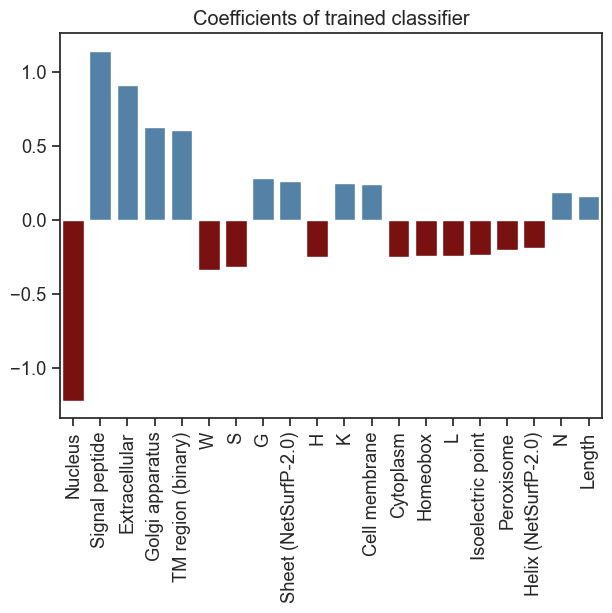

In [56]:
n = 2 # minimum study criterion 

print("Number of features:", len(coef_final_model_l2[n-1][coef_final_model_l2[n-1] != 0]))
coefs_plot_l2 = pd.DataFrame(coef_final_model_l2[n-1][:20])
coefs_plot_l2.rename(index=name_dict, inplace=True)
list_index_l2 = list(coefs_plot_l2.index)

sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

col = ["steelblue" if (x > 0) else "darkred" for x in coefs_plot_l2[n]]

sns.barplot(x=list_index_l2, y=n, data=coefs_plot_l2, palette=col)
ax.set(xlabel=None, ylabel=None, title="Coefficients of trained classifier")
# aplt.xticks(rotation=90)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()
fig.savefig(fig_path + "Logistic_classifier_coefficients_L2_2plus.png", bbox_inches="tight", dpi=300, transparent=True)

Number of features: 55


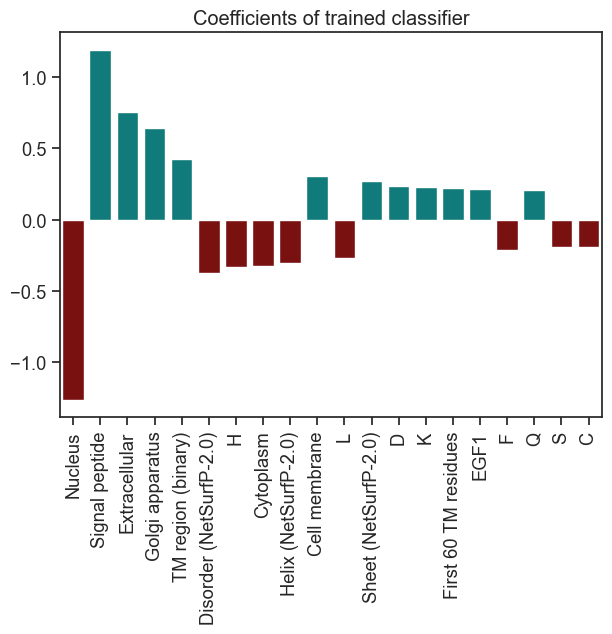

In [57]:
n = 3 # minimum study criterion 

print("Number of features:", len(coef_final_model_l2[n-1][coef_final_model_l2[n-1] != 0]))
coefs_plot_l2 = pd.DataFrame(coef_final_model_l2[n-1][:20])
coefs_plot_l2.rename(index=name_dict, inplace=True)
list_index_l2 = list(coefs_plot_l2.index)

sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

col = ["darkcyan" if (x > 0) else "darkred" for x in coefs_plot_l2[n]]

sns.barplot(x=list_index_l2, y=n, data=coefs_plot_l2, palette=col)
ax.set(xlabel=None, ylabel=None, title="Coefficients of trained classifier")
# aplt.xticks(rotation=90)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()
fig.savefig(fig_path + "Logistic_classifier_coefficients_L2_3plus.png", bbox_inches="tight", dpi=300, transparent=True)

In [48]:
# p-values for accuracy of models with more stringent training data
p_vals_l2 = []

for i in range(len(baclist_csf_l2)-1):
    _, p = ttest_ind(baclist_csf_l2[i], baclist_csf_l2[i+1])
    print("Comparison of %i and %i: %s" % (i+1, i+2, print_p_val(p)))
    p_vals_l2.append(p)
    
adjusted_p_bac_l2 = multipletests(p_vals_l2, alpha=0.05, method="fdr_bh")[1]

Comparison of 1 and 2: 0.0002
Comparison of 2 and 3: 0.0072
Comparison of 3 and 4: 0.2824
Comparison of 4 and 5: 0.0158
Comparison of 5 and 6: 0.5473


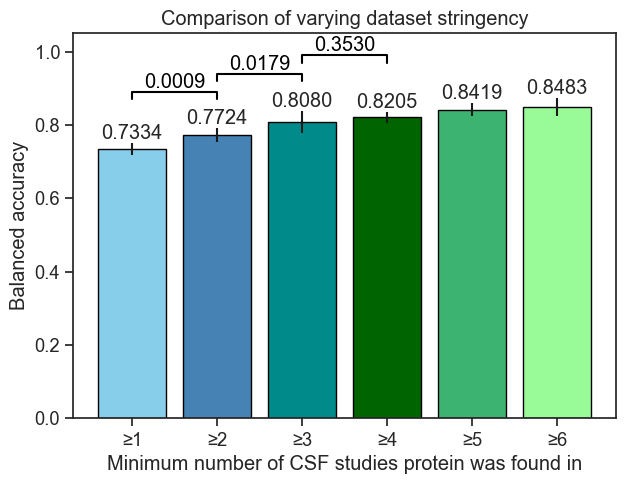

In [49]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

bars = ax.bar(x=["≥1","≥2","≥3","≥4","≥5","≥6"], height=[np.mean(i) for i in baclist_csf_l2], yerr=[np.std(i) for i in baclist_csf_l2], 
    color=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"], edgecolor="black")
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Minimum number of CSF studies protein was found in", ylabel="Balanced accuracy", 
    title="Comparison of varying dataset stringency", ylim=(0, 1.05))

# add p-value annotations
r, h = 0.87, 0.02
ax.plot([0, 0, 1, 1], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(0.5, r+0.02, print_p_val(adjusted_p_bac_l2[0]), ha="center", va="bottom", color="black")
r, h = 0.92, 0.02
ax.plot([1, 1, 2, 2], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(1.5, r+0.02, print_p_val(adjusted_p_bac_l2[1]), ha="center", va="bottom", color="black")
r, h = 0.97, 0.02
ax.plot([2, 2, 3, 3], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(2.5, r+0.02, print_p_val(adjusted_p_bac_l2[2]), ha="center", va="bottom", color="black")

plt.show()
fig.savefig(fig_path + "Increased_dataset_stringency_CSF_BAC_L2.png", bbox_inches="tight", dpi=300)

In [50]:
# p-values for accuracy of models with more stringent training data
p_vals_l2_auc = []

for i in range(len(auclist_csf_l2)-1):
    _, p = ttest_ind(auclist_csf_l2[i], auclist_csf_l2[i+1])
    print("Comparison of %i and %i: %s" % (i+1, i+2, print_p_val(p)))
    p_vals_l2_auc.append(p)
    
adjusted_p_auc_l2 = multipletests(p_vals_l2_auc, alpha=0.05, method="fdr_bh")[1]

Comparison of 1 and 2: < 0.0001
Comparison of 2 and 3: 0.0099
Comparison of 3 and 4: 0.5058
Comparison of 4 and 5: 0.0092
Comparison of 5 and 6: 0.5596


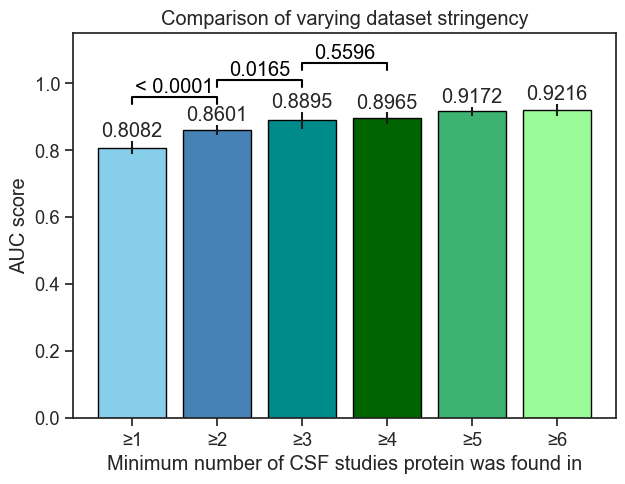

In [51]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

bars = ax.bar(x=["≥1","≥2","≥3","≥4","≥5","≥6"], height=[np.mean(i) for i in auclist_csf_l2], yerr=[np.std(i) for i in auclist_csf_l2],
    color=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"], edgecolor="black")
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Minimum number of CSF studies protein was found in", ylabel="AUC score", 
    title="Comparison of varying dataset stringency", ylim=(0, 1.15))

# add p-value annotations
r, h = 0.94, 0.02
ax.plot([0, 0, 1, 1], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(0.5, r+0.02, print_p_val(adjusted_p_auc_l2[0]), ha="center", va="bottom", color="black")
r, h = 0.99, 0.02
ax.plot([1, 1, 2, 2], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(1.5, r+0.02, print_p_val(adjusted_p_auc_l2[1]), ha="center", va="bottom", color="black")
r, h = 1.04, 0.02
ax.plot([2, 2, 3, 3], [r, r+h, r+h, r], lw=1.5, color="black")
ax.text(2.5, r+0.02, print_p_val(adjusted_p_auc_l2[2]), ha="center", va="bottom", color="black")

plt.show()

fig.savefig(fig_path + "Increased_dataset_stringency_CSF_AUC_L2.png", bbox_inches="tight", dpi=300)

### Brain 

In [49]:
baclist_brain = []
auclist_brain = []

brain_sets = [brain_tissue_enhanced, brain_group_enriched, brain_tissue_enriched]

print("Number of brain proteins:", len(df_features))

for i in range(len(brain_sets)):
    print("-------------")
    df_stringent = increase_stringency_brain(df_features, brain_sets[i])
    bac, auc, cm = accuracy_stringent(df_stringent, n=i)
    
    baclist_brain.append(bac)
    auclist_brain.append(auc)

Number of brain proteins: 2079
-------------
Number of brain proteins to be removed: 0
Number of CSF proteins left: 889
Number of non-CSF proteins left: 1190
-------------
Number of brain proteins to be removed: 1219
Number of CSF proteins left: 377
Number of non-CSF proteins left: 483
-------------
Number of brain proteins to be removed: 1708
Number of CSF proteins left: 174
Number of non-CSF proteins left: 197


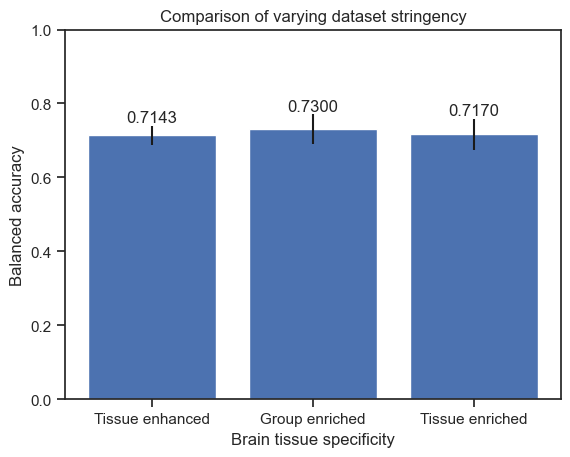

In [50]:
fig, ax = plt.subplots()

bars = ax.bar(x=["Tissue enhanced", "Group enriched", "Tissue enriched"], height=[np.mean(i) for i in baclist_brain], yerr=[np.std(i) for i in baclist_brain])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Brain tissue specificity", ylabel="Balanced accuracy", 
    title="Comparison of varying dataset stringency", ylim=(0, 1))
plt.show()

fig.savefig(fig_path + "Increased_dataset_stringency_brain_specifcity_BAC.png", bbox_inches="tight")

In [51]:
baclist_brain = []
auclist_brain = []

brain_sets = [brain_all, brain_many, brain_some, brain_single]

print("Number of brain proteins:", len(df_features))

for i in range(len(brain_sets)):
    print("-------------")
    df_stringent = increase_stringency_brain(df_features, brain_sets[i])
    bac, auc, cm = accuracy_stringent(df_stringent, n=i)
    
    baclist_brain.append(bac)
    auclist_brain.append(auc)

Number of brain proteins: 2079
-------------
Number of brain proteins to be removed: 0
Number of CSF proteins left: 889
Number of non-CSF proteins left: 1190
-------------
Number of brain proteins to be removed: 319
Number of CSF proteins left: 747
Number of non-CSF proteins left: 1013
-------------
Number of brain proteins to be removed: 1283
Number of CSF proteins left: 277
Number of non-CSF proteins left: 519
-------------
Number of brain proteins to be removed: 2012
Number of CSF proteins left: 21
Number of non-CSF proteins left: 46


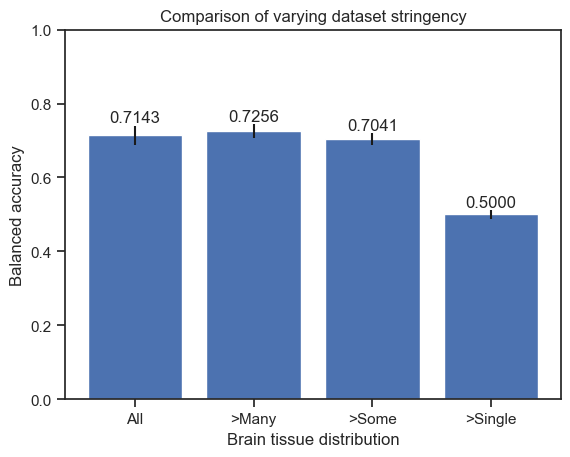

In [52]:
fig, ax = plt.subplots()

bars = ax.bar(x=["All", ">Many", ">Some", ">Single"], height=[np.mean(i) for i in baclist_brain], yerr=[np.std(i) for i in baclist_brain])
ax.bar_label(bars, fmt="%.4f")
ax.set(xlabel="Brain tissue distribution", ylabel="Balanced accuracy", 
    title="Comparison of varying dataset stringency", ylim=(0, 1))
plt.show()

fig.savefig(fig_path + "Increased_dataset_stringency_brain_distribution_BAC.png", bbox_inches="tight")

## Feature analysis of models trained on more stringent CSF data

In [53]:
def stringent_dataset_analysis(df, model="L2", save_model=False, model_name=None):
    
    # define explanatory and response variables
    X = (df.drop(["Uniprot", "Sequence", "CSF"], axis=1))
    y = (df["CSF"])
    
    coefs = []
    
    for i in range(10):
        
        # preprocessing 
        X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y, random_state=i)  

        # train model
        if model == "L1":
            clf = LogisticRegression(penalty="l1", solver="saga", C=0.1, max_iter=10000, dual=False, 
                random_state=0).fit(X_train_bal, y_train_bal)
        if model == "L2":
            clf = LogisticRegression(penalty="l2", C=0.1, max_iter=1000, dual=False, random_state=0).fit(X_train_bal, y_train_bal)     
        
        # extract coefficients
        coef = pd.Series(index=X_train_bal.columns, data=clf.coef_[0], name=i)
        coef.sort_values(ascending=False, key=abs, inplace=True)
        coefs.append(coef)
    
#     print(coef[:20])
    
    # merge all coefficient series into oen dataframe
    coefs_df = pd.merge(coefs[0], coefs[1], left_index=True, right_index=True)
    for i in range(2, len(coefs)):
        coefs_df = pd.merge(coefs_df, coefs[i], left_index=True, right_index=True)  
                        
    coefs_df["Mean"] = coefs_df.mean(axis=1)
    coefs_df["Standard deviation"] = coefs_df.std(axis=1)
    
    if save_model == True:
        with open(os.getcwd() + "/Models/" + model_name + ".pkl", "wb") as f:  
            pickle.dump(clf, f)
                        
    return coefs_df

In [54]:
# create more stringent data sets
df_features_2plus = increase_stringency_CSF(df_features, csf, 2)
print("Number of proteins in dataset:", len(df_features_2plus))
print("-------------")
df_features_3plus = increase_stringency_CSF(df_features, csf, 3)
print("Number of proteins in dataset:", len(df_features_3plus))

Number of CSF proteins to be removed: 244
Number of CSF proteins left: 645
Number of proteins in dataset: 1835
-------------
Number of CSF proteins to be removed: 369
Number of CSF proteins left: 520
Number of proteins in dataset: 1710


In [55]:
model="LogisticClassifier"
coefs_df = stringent_dataset_analysis(df_features, model=model, save_model=True, 
    model_name= model + "_L1").reset_index()
coefs_df_2plus = stringent_dataset_analysis(df_features_2plus, model=model, save_model=True, 
    model_name= model + "_L1_2plus").reset_index()
coefs_df_3plus = stringent_dataset_analysis(df_features_3plus, model=model, save_model=True, 
    model_name=model + "_L1_3plus").reset_index()

In [56]:
all_coefs = coefs_df[["index", "Mean", "Standard deviation"]].merge(coefs_df_2plus[["index", "Mean", "Standard deviation"]], on="index",
    suffixes=(None, "_2_plus"))
all_coefs = all_coefs.merge(coefs_df_3plus[["index", "Mean", "Standard deviation"]], on="index",
    suffixes=(None, "_3_plus"))
all_coefs.sort_values("Mean", ascending=False, key=abs)[:20]

,index,Mean,Standard deviation,Mean_2_plus,Standard deviation_2_plus,Mean_3_plus,Standard deviation_3_plus
0,Signal peptide,1.344289,0.150626,1.642296,0.206032,1.771193,0.272608
1,Nucleus,-1.235393,0.139321,-1.695061,0.195197,-2.156439,0.231945
2,Golgi_apparatus,1.054403,0.253582,1.195507,0.399088,1.166500,0.360655
3,Extracellular,0.745398,0.137250,1.009066,0.355064,0.844013,0.288264
4,DNA_binding,-0.585126,0.194673,-0.924002,0.094090,-0.844296,0.317220
7,PredHel_binary,0.560537,0.138659,0.643534,0.192111,0.694427,0.279078
9,PS00027,-0.477716,0.294435,-0.024241,0.072724,0.000000,0.000000
5,PS00028,-0.438541,0.166670,0.000000,0.000000,0.000000,0.000000
6,PS00022,0.345391,0.212364,0.230236,0.205044,0.261089,0.233131
10,Polarity_low,-0.328907,0.198046,-0.360165,0.274588,-0.098917,0.157800


In [57]:
all_coefs_melted = pd.melt(all_coefs, id_vars="index", value_vars=["Mean", "Mean_2_plus", "Mean_3_plus"], 
    var_name="Stringency", value_name="Coefficient")
all_coefs_melted.sort_values("index", inplace=True)
all_coefs_melted

,index,Stringency,Coefficient
182,A,Mean_3_plus,0.047484
107,A,Mean_2_plus,0.001568
32,A,Mean,0.017257
61,Buried,Mean,0.000000
211,Buried,Mean_3_plus,0.000000
...,...,...,...
170,W,Mean_3_plus,-0.215941
95,W,Mean_2_plus,-0.263075
45,Y,Mean,-0.001441
120,Y,Mean_2_plus,-0.007712


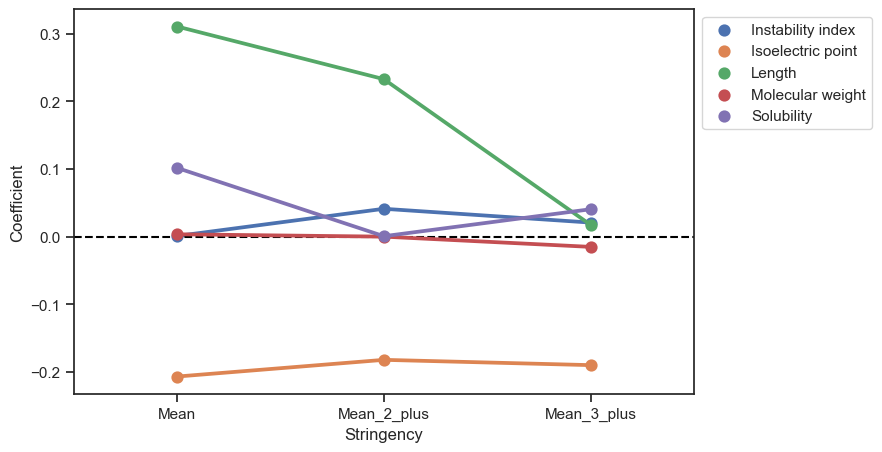

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

features=["Length", "Molecular weight", "Isoelectric point", "Instability index", "Solubility"]

sns.pointplot(x="Stringency", y="Coefficient", hue="index", data=all_coefs_melted[all_coefs_melted["index"].isin(features)], 
    order=["Mean", "Mean_2_plus", "Mean_3_plus"])
ax.axhline(y=0, color="black", linestyle="--")
ax.legend(bbox_to_anchor=(1.3, 1))
plt.show()

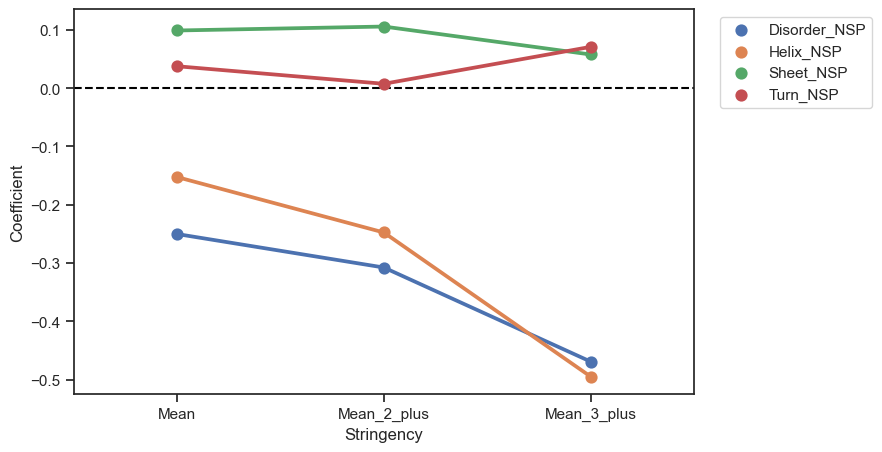

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

features=["Disorder_NSP", "Helix_NSP", "Turn_NSP", "Sheet_NSP"]

sns.pointplot(x="Stringency", y="Coefficient", hue="index", data=all_coefs_melted[all_coefs_melted["index"].isin(features)], 
    order=["Mean", "Mean_2_plus", "Mean_3_plus"])
ax.axhline(y=0, color="black", linestyle="--")
ax.legend(bbox_to_anchor=(1.3, 1))
plt.show()

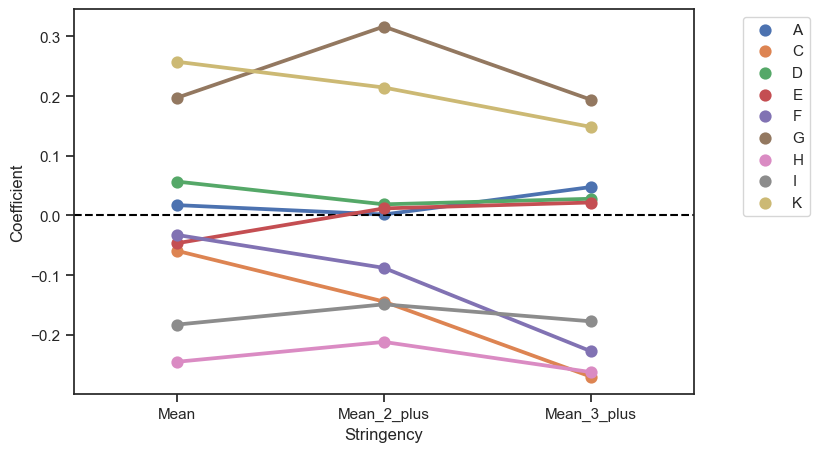

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

features=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K']

sns.pointplot(x="Stringency", y="Coefficient", hue="index", data=all_coefs_melted[all_coefs_melted["index"].isin(features)], 
    order=["Mean", "Mean_2_plus", "Mean_3_plus"])
ax.axhline(y=0, color="black", linestyle="--")
ax.legend(bbox_to_anchor=(1.2, 1))
plt.show()

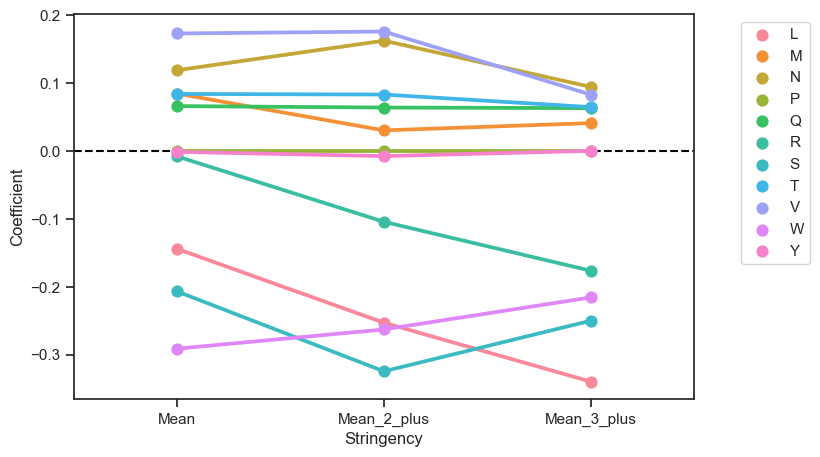

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

features=['L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

sns.pointplot(x="Stringency", y="Coefficient", hue="index", data=all_coefs_melted[all_coefs_melted["index"].isin(features)], 
    order=["Mean", "Mean_2_plus", "Mean_3_plus"])
ax.axhline(y=0, color="black", linestyle="--")
ax.legend(bbox_to_anchor=(1.2, 1))
plt.show()

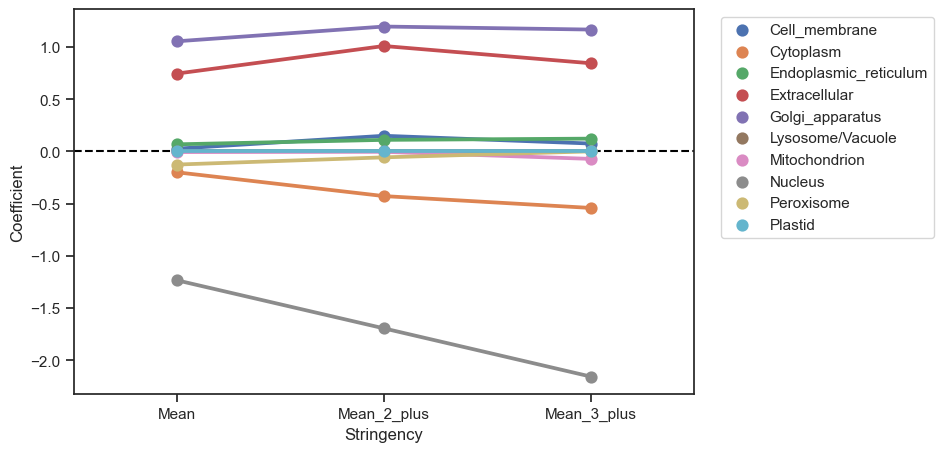

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

features=["Signal_peptide", "Cytoplasm", "Extracellular", "Lysosome/Vacuole", "Nucleus", "Cell_membrane", "Endoplasmic_reticulum", "Mitochondrion",
          "Golgi_apparatus", "Peroxisome", "Plastid"]

sns.pointplot(x="Stringency", y="Coefficient", hue="index", data=all_coefs_melted[all_coefs_melted["index"].isin(features)], 
    order=["Mean", "Mean_2_plus", "Mean_3_plus"])
ax.axhline(y=0, color="black", linestyle="--")
ax.legend(bbox_to_anchor=(1.4, 1))
plt.show()

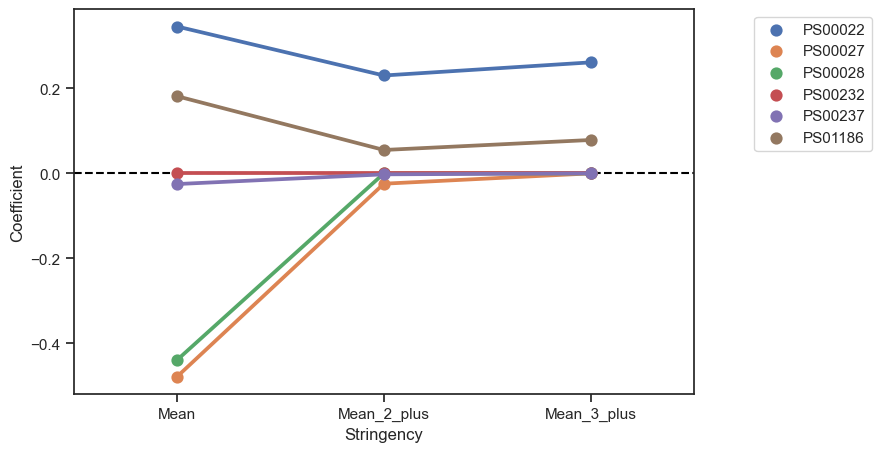

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

features=["PS00232", "PS00237", "PS00027", "PS00028", "PS00022", "PS01186"]

sns.pointplot(x="Stringency", y="Coefficient", hue="index", data=all_coefs_melted[all_coefs_melted["index"].isin(features)], 
    order=["Mean", "Mean_2_plus", "Mean_3_plus"])
ax.axhline(y=0, color="black", linestyle="--")
ax.legend(bbox_to_anchor=(1.3, 1))
plt.show()

## Decision tree

In [65]:
dt = DecisionTreeClassifier()
dt.fit(X_train_bal, y_train_bal)

DecisionTreeClassifier()

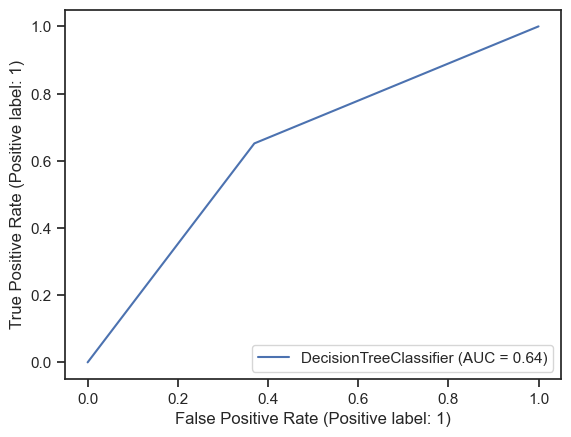

In [66]:
RocCurveDisplay.from_estimator(dt, X_test_scal, y_test)
plt.show()

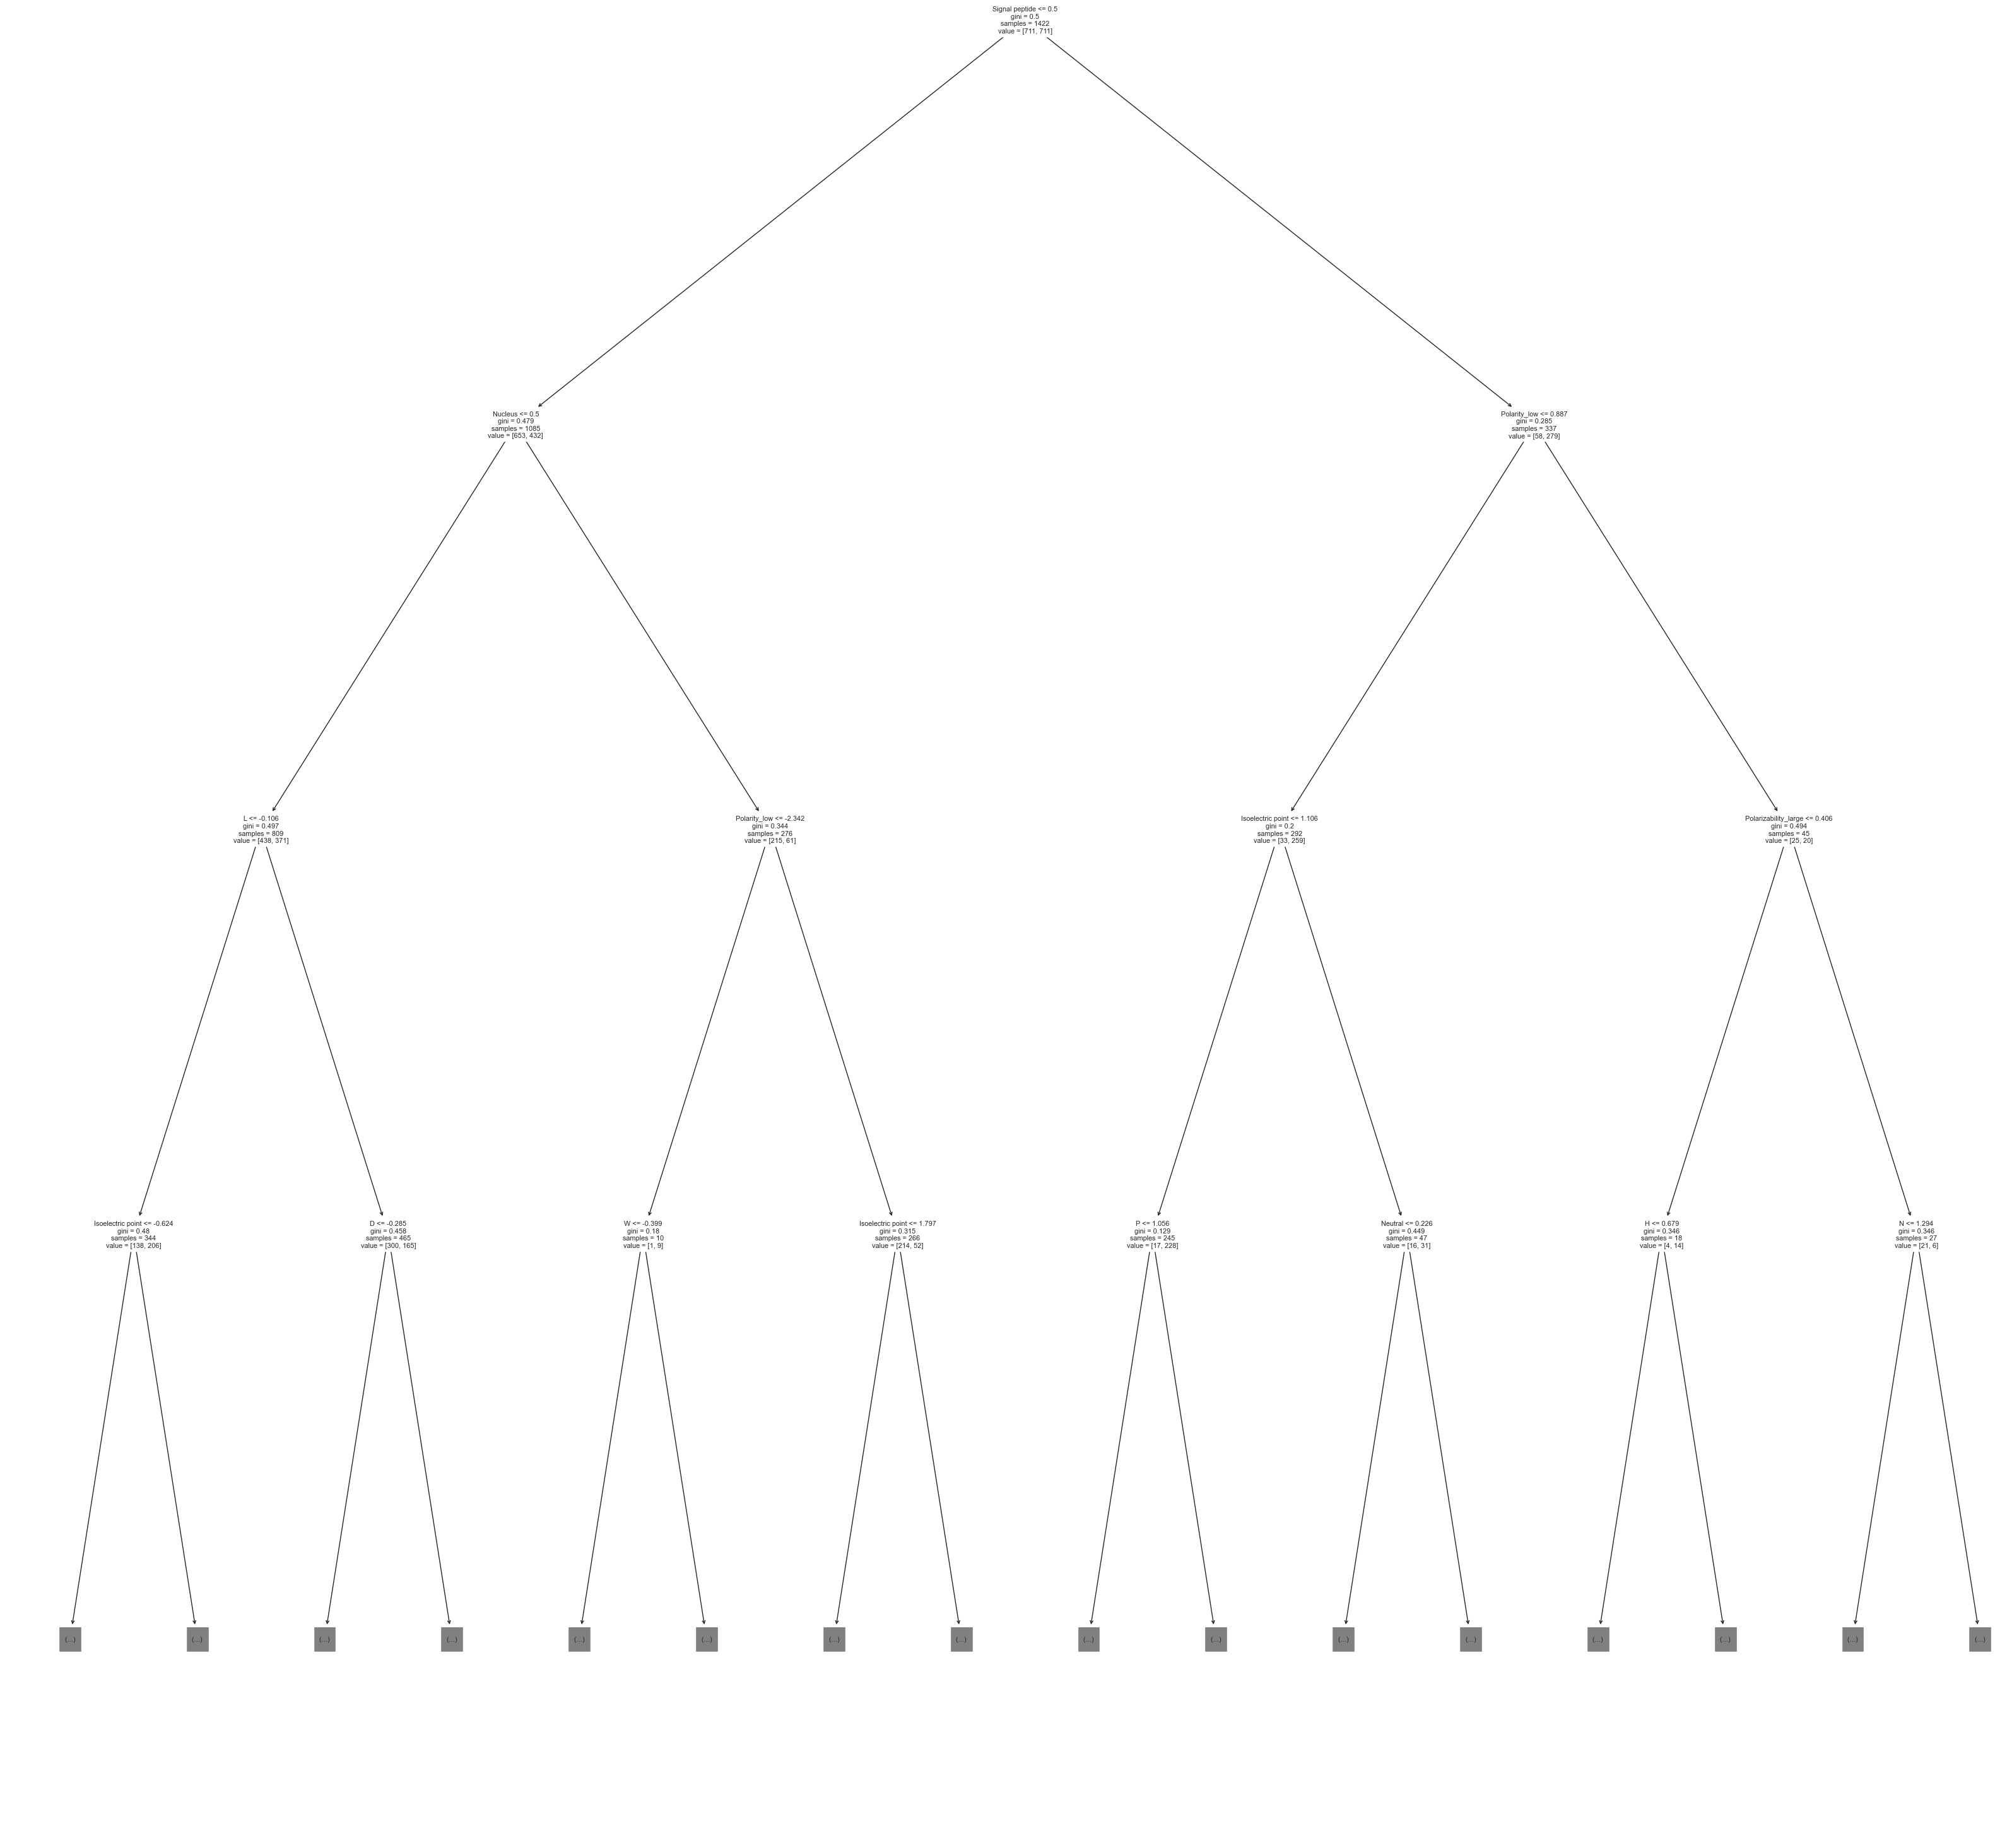

In [67]:
fig, ax = plt.subplots(figsize=(30,30))

plot_tree(dt, max_depth=3, feature_names=X_train_bal.columns)
plt.show()